In [1]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
import numpy as np
import re
import math
import seaborn as sns
from matplotlib import pyplot as plt
from collections import defaultdict
from IPython.core.display import display, HTML
import pickle
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
#display(HTML(my_html))     # make sure Jupyter knows to display it as HTML

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder

In [2]:
dirs = {'fassbinder': 'https://www.imdb.com/name/nm0001202/', \
        'godard':'https://www.imdb.com/name/nm0000419/', \
        'hitchcock': 'https://www.imdb.com/name/nm0000033', \
        'spielberg': 'https://www.imdb.com/name/nm0000229', \
        'kurosawa': 'https://www.imdb.com/name/nm0000041/', \
        'bergman': 'https://www.imdb.com/name/nm0000005/', \
        'allen': 'https://www.imdb.com/name/nm0000095',\
        'herzog': 'https://www.imdb.com/name/nm0001348/',
        'scorsese': 'https://www.imdb.com/name/nm0000217/'}
        # scorcese

dirs_box_office = {'godard':'https://www.the-numbers.com/person/55430401-Jean-Luc-Godard#tab=technical', \
                   'hitchcock':'https://www.the-numbers.com/person/66230401-Alfred-Hitchcock#tab=technical', \
                   'spielberg': 'https://www.the-numbers.com/person/135430401-Steven-Spielberg#tab=technical',\
                   'allen':'https://www.the-numbers.com/person/4010401-Woody-Allen#tab=technical', \
                   'bergman': 'https://www.the-numbers.com/person/13600401-Ingmar-Bergman#tab=technical',\
                   'herzog':'https://www.the-numbers.com/person/65080401-Werner-Herzog#tab=technical',
                   'scorsese': 'https://www.the-numbers.com/person/128910401-Martin-Scorsese#tab=technical'}

In [3]:
director = 'scorsese'

In [4]:

dirs_page = dirs[director]
url = dirs_page
response = requests.get(url)
print( response.status_code )
page = response.text
soup = BeautifulSoup(page, "lxml")
#need to distinguish 'filmo-head-director' from 'assistant_director' etc.
head_director_soup = soup.find('div', id='filmo-head-director')
head_director_section_soup= head_director_soup.find_next_sibling('div', class_='filmo-category-section')
films = head_director_section_soup.find_all('div', class_=re.compile('filmo-row'), id=re.compile("director"))
#films = soup.find_all('div', class_=re.compile('filmo-row'), id=re.compile("director"))

200


* Clean the datapoints below
* Ensure they are available or handled for each film's page
* Convert into numeric datatypes
* Populate a list of dictionaries with these 
* Within the loop that goes through every flick, populate the list of dictionaries with these
* Do one-hot-encoding on categorical variables
* Train and test the linear regression model

In [5]:
def is_tv_series( the_film_soup ):
    try:
        parenthesis = the_film_soup.find('a').next
        try:
            if 'TV ' in parenthesis.next:
                return True
            else:
                return False
        except:
            return False
    except:
        return False

In [6]:
def is_documentary( the_film_soup ):
    try:
        parenthesis = the_film_soup.find('a').next
        #print(parenthesis)
        try:
            if 'documentary' in parenthesis.next.lower():
                return 1
            else:
                return 0
        except:
            return 0
    except:
        return 0

In [7]:
def parse_crew_data(the_crew_soup):
    crew_data = {}
    try: 
        #print( the_crew_soup.find('h4', id='cinematographer').next_sibling )
        crew_data['cinematographer'] = the_crew_soup.find('h4', id='cinematographer').find_next_sibling('table', class_='simpleTable').find('a').text.strip()
    except: 
        crew_data['cinematographer'] = ''
    return (crew_data)

In [8]:
def parse_cast_data(the_film_soup):
    try:
        cast_table = the_film_soup.find('table', class_='cast_list').find_all('td', class_='primary_photo')
        cast_list = [(row.find_next_sibling().text.strip(), 1) for row in cast_table ]
        #cast_dict= defaultdict(cast_list)
        #cast_dict.setdefault(1)
        cast_dict = dict(cast_list)
        #print(cast_dict)
        return(cast_dict)
        #return(  the_film_soup.find('table', class_='cast_list').find_all('a', class_='primary_photo').find_next_sibling().text )
        
  #     the_film_soup.find('table', class_='cast_list').find_all('a', class_=re.compile('filmo-row'), id=re.compile("director"))
  #  return the_film_soup.find('table', class_='cast_list').find('a')
    except:
        return dict()

In [9]:
#crew_url = test_url + '/fullcredits'
crew_url = 'https://www.imdb.com/title/tt0084654/fullcredits'
crew_response = requests.get(crew_url)
crew_page = crew_response.text
crew_soup = BeautifulSoup(crew_page, "lxml")

the_crew_data = parse_crew_data( crew_soup )
#print(the_crew_data)
#print(is_tv_series(test_row))

In [10]:
def get_film_data_only_title( film_soup ):
    film_title_string = film_soup.find(class_ = 'title_wrapper').find('h1').text
    print(film_title_string)
    
# searching from the page_content might be more efficient. To be tested later
def parse_film_data( film_soup ):
    film_data = {}
    
    try:        
        film_title_string = (film_soup.find(class_ = 'title_wrapper').find('h1').text).strip()
    except:
        film_title_string = ''
    title_line = film_title_string.split('\xa0(')
    film_data['title'] = title_line[0].replace('\xa0','').rstrip() # title part of title line
    
    film_data['year'] = title_line[1].replace(') ', '').strip(')') if len(title_line) > 1 else '' # year part of title line
    
    try:
        film_rating_tag = film_soup.find('span', itemprop='ratingValue')
        try:
            film_rating_string = film_rating_tag.text   #find_next_sibling().text
        except:
            film_rating_string = None      
    except:
        film_rating_string = None 
    film_data['rating'] = film_rating_string
   
    try:
        film_rating_count_tag = film_soup.find('span', itemprop='ratingCount')
        try:
            film_rating_count = float( film_rating_count_tag.text.replace(',', '')) #find_next_sibling().text
        except:
            film_rating_count = None 
    except:
            film_rating_count = None 
    film_data['rating_count'] = film_rating_count
    
    try:
        film_duration_string = film_soup.find('time').text
        dur_list = film_duration_string.replace('min','').rstrip().split('h ')
        film_data['duration'] = (int(dur_list[-1]) + 60*int(dur_list[0])) if (len(dur_list)>1) else int(dur_list[-1])
    except:
        film_data['duration'] = None
      
    try:
        film_date_string = film_soup.find('a', title='see more release dates')
    except:
        film_date_string = ''  
    
    try:
        film_release_date_tag = film_soup.find('h4', text=re.compile('Release Date:'))
        try:
            film_release_date = film_release_date_tag.next_sibling.replace('\n', '')
        except:
            film_release_date = '' 
    except:
            film_release_date = '' 
    film_data['release_date'] = film_release_date
    
    
    try:
        film_metacritic_score_tag = film_soup.find('div', class_=re.compile('metacriticScore'))
        try:
            film_metacritic_score = film_metacritic_score_tag.find('span').text
        except:
            film_metacritic_score = None #math.nan  
    except:
        film_metacritic_score = None #math.nan  
    film_data['metacritic_score'] = film_metacritic_score
    try:
        film_details = film_soup.find('div', class_='article', id='titleDetails')
        try:        
            film_gross_string = film_details.find('h4', text=re.compile('Cumulative Worldwide Gross:')).next_sibling
            film_gross = int( re.sub("[^0-9]", "", film_gross_string ))
        except:
             film_gross = None 
    except:
        film_gross = None 
    film_data['worldwide_gross_imdb']  = film_gross
    
    try:
        film_runtime_tag = film_soup.find('h4', text=re.compile('Runtime:'))
        try:
             film_runtime = int(film_runtime_tag.find_next_sibling().text.strip(' min'))
        except:
            film_runtime = None 
    except:
            film_runtime = None
    film_data['runtime'] = film_runtime
    try:
        film_budget_tag = film_soup.find('h4', text=re.compile('Budget'))
        try:
            film_budget = int( re.sub("[^0-9]", "", film_budget_tag.next_sibling ))
        except:
            film_budget = None #math.nan  
    except:
            film_budget = None #math.nan  
    film_data['budget'] = film_budget
      
    return film_data

In [11]:
list_of_films = []
dict_of_all_actors = {}

index_ = 0 # temporary for record keeping
for film in films:
    cast_dict = {}
    if ( not is_tv_series(film)): 
        film_url_suffix = film.find('a').get('href')
        film_url = 'https://imdb.com' + film_url_suffix
        print('\n', film_url)
        film_response = requests.get(film_url)
        if(film_response.status_code < 400):
            film_page = film_response.text
            film_soup = BeautifulSoup(film_page, "lxml")
            film_record = parse_film_data( film_soup )
            film_record['tv_series'] = 0
    else:  # To be customized 
        film_url_suffix = film.find('a').get('href')
        film_url = 'https://imdb.com' + film_url_suffix
        print('\n', film_url)
        film_response = requests.get(film_url)
        if(film_response.status_code < 400):
            film_page = film_response.text
            film_soup = BeautifulSoup(film_page, "lxml")
            film_record = parse_film_data( film_soup )
            film_record['tv_series'] = 1
            
    film_record['documentary'] = is_documentary(film)
    #print(film_record)
    
    crew_url = film_url + 'fullcredits'
   # print(crew_url)
    crew_response = requests.get(crew_url)
    crew_page = crew_response.text
    crew_soup = BeautifulSoup(crew_page, "lxml")
    film_record.update( parse_crew_data(crew_soup) )
    cast_dict = parse_cast_data(film_soup)
    film_record.update( cast_dict )
    dict_of_all_actors.update( cast_dict )
    #dict_of_all_actors = parse_cast_data(film_soup)
   
    print(index_) # temporary for record keeping
    print(film_record)
    
    list_of_films.append(film_record)
    index_+=1
    
film_catalog = pd.DataFrame(list_of_films )


 https://imdb.com/title/tt7428530/
0
{'title': 'Roosevelt', 'year': '', 'rating': None, 'rating_count': None, 'duration': None, 'release_date': '', 'metacritic_score': None, 'worldwide_gross_imdb': None, 'runtime': None, 'budget': None, 'tv_series': 0, 'documentary': 0, 'cinematographer': '', 'Leonardo DiCaprio': 1}

 https://imdb.com/title/tt0959300/
1
{'title': 'The Devil in the White City', 'year': '', 'rating': None, 'rating_count': None, 'duration': None, 'release_date': '', 'metacritic_score': None, 'worldwide_gross_imdb': None, 'runtime': None, 'budget': None, 'tv_series': 1, 'documentary': 0, 'cinematographer': '', 'Leonardo DiCaprio': 1}

 https://imdb.com/title/tt5537002/
2
{'title': 'Killers of the Flower Moon', 'year': '', 'rating': None, 'rating_count': None, 'duration': None, 'release_date': '', 'metacritic_score': None, 'worldwide_gross_imdb': None, 'runtime': None, 'budget': 200000000, 'tv_series': 0, 'documentary': 0, 'cinematographer': 'Rodrigo Prieto', 'Leonardo DiC

16
{'title': 'George Harrison: Living in the Material World', 'year': '2011', 'rating': '8.2', 'rating_count': 10599.0, 'duration': 208, 'release_date': ' 4 October 2011 (UK)    ', 'metacritic_score': None, 'worldwide_gross_imdb': 156113, 'runtime': 208, 'budget': None, 'tv_series': 0, 'documentary': 1, 'cinematographer': 'Martin Kenzie', 'George Harrison': 1, 'Paul McCartney': 1, 'John Lennon': 1, 'Ringo Starr': 1, 'Louise Harrison': 1, 'Harold Harrison': 1, 'Harry Harrison': 1, 'Peter Harrison': 1, 'Olivia Harrison': 1, 'Dhani Harrison': 1, 'Eric Clapton': 1, 'Pattie Boyd': 1, 'Pete Best': 1, 'Cynthia Lennon': 1, 'Julian Lennon': 1}

 https://imdb.com/title/tt13515268/
17
{'title': 'Bleu de Chanel', 'year': '2010', 'rating': '6.2', 'rating_count': 9.0, 'duration': 1, 'release_date': '', 'metacritic_score': None, 'worldwide_gross_imdb': None, 'runtime': 1, 'budget': None, 'tv_series': 0, 'documentary': 0, 'cinematographer': 'Stuart Dryburgh', 'Amalie Bruun': 1, 'Larry Kaplan': 1, 'Ing

26
{'title': 'The Aviator', 'year': '2004', 'rating': '7.5', 'rating_count': 333771.0, 'duration': 170, 'release_date': ' 25 December 2004 (USA)    ', 'metacritic_score': '77', 'worldwide_gross_imdb': 213719942, 'runtime': 170, 'budget': 110000000, 'tv_series': 0, 'documentary': 0, 'cinematographer': 'Robert Richardson', 'Leonardo DiCaprio': 1, 'Cate Blanchett': 1, 'Kate Beckinsale': 1, 'John C. Reilly': 1, 'Alec Baldwin': 1, 'Alan Alda': 1, 'Ian Holm': 1, 'Danny Huston': 1, 'Gwen Stefani': 1, 'Jude Law': 1, 'Adam Scott': 1, 'Matt Ross': 1, 'Kelli Garner': 1, 'Frances Conroy': 1, 'Brent Spiner': 1}

 https://imdb.com/title/tt0397507/
27
{'title': 'Lady by the Sea: The Statue of Liberty', 'year': '2004', 'rating': '6.0', 'rating_count': 83.0, 'duration': 55, 'release_date': ' 14 January 2004 (USA)    ', 'metacritic_score': None, 'worldwide_gross_imdb': None, 'runtime': None, 'budget': 10000, 'tv_series': 1, 'documentary': 1, 'cinematographer': 'Robert Shepard', 'Phillip Lopate': 1, 'Jam

38
{'title': 'Casino', 'year': '1995', 'rating': '8.2', 'rating_count': 465192.0, 'duration': 178, 'release_date': ' 22 November 1995 (USA)    ', 'metacritic_score': '73', 'worldwide_gross_imdb': 116112375, 'runtime': 178, 'budget': 52000000, 'tv_series': 0, 'documentary': 0, 'cinematographer': 'Robert Richardson', 'Robert De Niro': 1, 'Sharon Stone': 1, 'Joe Pesci': 1, 'James Woods': 1, 'Don Rickles': 1, 'Alan King': 1, 'Kevin Pollak': 1, 'L.Q. Jones': 1, 'Dick Smothers': 1, 'Frank Vincent': 1, 'John Bloom': 1, 'Pasquale Cajano': 1, 'Melissa Prophet': 1, 'Bill Allison': 1, 'Vinny Vella': 1}

 https://imdb.com/title/tt0106226/
39
{'title': 'The Age of Innocence', 'year': '1993', 'rating': '7.2', 'rating_count': 52892.0, 'duration': 139, 'release_date': ' 1 October 1993 (USA)    ', 'metacritic_score': '90', 'worldwide_gross_imdb': 32255440, 'runtime': 139, 'budget': 34000000, 'tv_series': 0, 'documentary': 0, 'cinematographer': 'Michael Ballhaus', 'Daniel Day-Lewis': 1, 'Michelle Pfeiff

52
{'title': 'Raging Bull', 'year': '1980', 'rating': '8.2', 'rating_count': 321207.0, 'duration': 129, 'release_date': ' 19 December 1980 (USA)    ', 'metacritic_score': '89', 'worldwide_gross_imdb': 23402427, 'runtime': 129, 'budget': 18000000, 'tv_series': 0, 'documentary': 0, 'cinematographer': 'Michael Chapman', 'Robert De Niro': 1, 'Cathy Moriarty': 1, 'Joe Pesci': 1, 'Frank Vincent': 1, 'Nicholas Colasanto': 1, 'Theresa Saldana': 1, 'Mario Gallo': 1, 'Frank Adonis': 1, 'Joseph Bono': 1, 'Frank Topham': 1, 'Lori Anne Flax': 1, 'Charles Scorsese': 1, 'Don Dunphy': 1, 'Bill Hanrahan': 1, 'Rita Bennett': 1}

 https://imdb.com/title/tt0077157/
53
{'title': 'American Boy: A Profile of - Steven Prince', 'year': '1978', 'rating': '7.3', 'rating_count': 1190.0, 'duration': 55, 'release_date': ' October 1978 (USA)    ', 'metacritic_score': None, 'worldwide_gross_imdb': None, 'runtime': 55, 'budget': 155000, 'tv_series': 0, 'documentary': 1, 'cinematographer': 'Michael Chapman', 'Steven Pr

67
{'title': "What's a Nice Girl Like You Doing in a Place Like This?", 'year': '1963', 'rating': '6.4', 'rating_count': 1761.0, 'duration': 9, 'release_date': ' 1963 (USA)    ', 'metacritic_score': None, 'worldwide_gross_imdb': None, 'runtime': 9, 'budget': None, 'tv_series': 0, 'documentary': 0, 'cinematographer': 'James Newman', 'Zeph Michaelis': 1, 'Mimi Stark': 1, 'Sarah Braveman': 1, 'Fred Sica': 1, 'Robert Uricola': 1}

 https://imdb.com/title/tt0053416/
68
{'title': 'Vesuvius VI', 'year': '1959', 'rating': '7.4', 'rating_count': 149.0, 'duration': 10, 'release_date': '', 'metacritic_score': None, 'worldwide_gross_imdb': None, 'runtime': 10, 'budget': None, 'tv_series': 0, 'documentary': 0, 'cinematographer': 'Martin Scorsese'}


In [12]:
film_catalog['year'] = pd.to_numeric(film_catalog['year'])
film_catalog['rating'] = pd.to_numeric(film_catalog['rating'])
film_catalog['worldwide_gross_imdb'] = pd.to_numeric(film_catalog['worldwide_gross_imdb'])
film_catalog['budget'] = pd.to_numeric(film_catalog['budget'])
film_catalog['metacritic_score'] = pd.to_numeric(film_catalog['metacritic_score'])

In [13]:
len(film_catalog.columns)

2801

In [14]:
len(dict_of_all_actors)

2788

In [15]:
len(film_catalog.columns) - len(dict_of_all_actors)

13

In [16]:
first_cast_column = len(film_catalog.columns) - len(dict_of_all_actors)
first_cast_column

13

In [17]:
main_column_names = list(film_catalog.columns[:first_cast_column])
main_column_names 

['title',
 'year',
 'rating',
 'rating_count',
 'duration',
 'release_date',
 'metacritic_score',
 'worldwide_gross_imdb',
 'runtime',
 'budget',
 'tv_series',
 'documentary',
 'cinematographer']

In [18]:
film_catalog.iloc[:,first_cast_column:] # temporary, to check work

,Leonardo DiCaprio,Robert De Niro,Catherine O'Hara,Eugene Levy,Andrea Martin,Rick Moranis,Martin Short,Dave Thomas,Joe Flaherty,Jimmy Kimmel,...,Ira Rubin,Sam DeFazio,Bernard Weisberger,Victor Magnotta,Richard Sweeton,John Bivona,Zeph Michaelis,Mimi Stark,Sarah Braveman,Fred Sica
0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
65,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
66,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,...,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN
67,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0


In [19]:
import copy
df_actors = copy.deepcopy(film_catalog.iloc[:, first_cast_column:])
df_actors

,Leonardo DiCaprio,Robert De Niro,Catherine O'Hara,Eugene Levy,Andrea Martin,Rick Moranis,Martin Short,Dave Thomas,Joe Flaherty,Jimmy Kimmel,...,Ira Rubin,Sam DeFazio,Bernard Weisberger,Victor Magnotta,Richard Sweeton,John Bivona,Zeph Michaelis,Mimi Stark,Sarah Braveman,Fred Sica
0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
65,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
66,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,...,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN
67,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0


In [20]:
df_actors.sum().sort_values(ascending = False)

Robert De Niro          14.0
Martin Scorsese         10.0
Leonardo DiCaprio        9.0
Harvey Keitel            8.0
Joe Pesci                6.0
                        ... 
Bette Davis              1.0
Geraldine Fitzgerald     1.0
Greer Garson             1.0
Joan Givner              1.0
Fred Sica                1.0
Length: 2788, dtype: float64

In [21]:
df_actors_reordered = df_actors[df_actors.sum().sort_values(ascending = False).index]
df_actors_reordered

,Robert De Niro,Martin Scorsese,Leonardo DiCaprio,Harvey Keitel,Joe Pesci,Catherine Scorsese,Eric Clapton,Harry Northup,Victor Argo,Michael Stuhlbarg,...,A. Scott Berg,Rosamond Bernier,John Burgee,Dina Chandel,Eleanor Clark,Bette Davis,Geraldine Fitzgerald,Greer Garson,Joan Givner,Fred Sica
0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64,NaN,NaN,NaN,1.0,NaN,1.0,NaN,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
65,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
66,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
67,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0


In [22]:
df_trunk = copy.deepcopy(film_catalog .iloc[:, :first_cast_column])
df_trunk

,title,year,rating,rating_count,duration,release_date,metacritic_score,worldwide_gross_imdb,runtime,budget,tv_series,documentary,cinematographer
0,Roosevelt,NaN,NaN,NaN,NaN,,NaN,NaN,NaN,NaN,0,0,
1,The Devil in the White City,NaN,NaN,NaN,NaN,,NaN,NaN,NaN,NaN,1,0,
2,Killers of the Flower Moon,NaN,NaN,NaN,NaN,,NaN,NaN,NaN,200000000.0,0,0,Rodrigo Prieto
3,Untitled David Johansen/NY Dolls Documentary,NaN,NaN,NaN,NaN,,NaN,NaN,NaN,NaN,0,1,Ellen Kuras
4,An Afternoon with SCTV,NaN,NaN,NaN,NaN,,NaN,NaN,NaN,NaN,1,0,
...,...,...,...,...,...,...,...,...,...,...,...,...,...
64,I Call First,1967.0,6.6,8292.0,90.0,13 September 1968 (USA),63.0,16085.0,90.0,75000.0,0,0,Richard H. Coll
65,New York City... Melting Point,1966.0,7.0,46.0,NaN,,NaN,NaN,NaN,NaN,0,1,
66,"It's Not Just You, Murray!",1964.0,6.5,1406.0,15.0,February 1964 (USA),NaN,NaN,15.0,NaN,0,0,Richard H. Coll
67,What's a Nice Girl Like You Doing in a Place L...,1963.0,6.4,1761.0,9.0,1963 (USA),NaN,NaN,9.0,NaN,0,0,James Newman


In [23]:
film_catalog_cast_columns_reordered = pd.concat( [df_trunk, df_actors_reordered], axis=1)
film_catalog_cast_columns_reordered

,title,year,rating,rating_count,duration,release_date,metacritic_score,worldwide_gross_imdb,runtime,budget,...,A. Scott Berg,Rosamond Bernier,John Burgee,Dina Chandel,Eleanor Clark,Bette Davis,Geraldine Fitzgerald,Greer Garson,Joan Givner,Fred Sica
0,Roosevelt,NaN,NaN,NaN,NaN,,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,The Devil in the White City,NaN,NaN,NaN,NaN,,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Killers of the Flower Moon,NaN,NaN,NaN,NaN,,NaN,NaN,NaN,200000000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Untitled David Johansen/NY Dolls Documentary,NaN,NaN,NaN,NaN,,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,An Afternoon with SCTV,NaN,NaN,NaN,NaN,,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64,I Call First,1967.0,6.6,8292.0,90.0,13 September 1968 (USA),63.0,16085.0,90.0,75000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
65,New York City... Melting Point,1966.0,7.0,46.0,NaN,,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
66,"It's Not Just You, Murray!",1964.0,6.5,1406.0,15.0,February 1964 (USA),NaN,NaN,15.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
67,What's a Nice Girl Like You Doing in a Place L...,1963.0,6.4,1761.0,9.0,1963 (USA),NaN,NaN,9.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0


In [24]:
film_catalog_cast_columns_reordered.iloc[:, :15].head(50)

,title,year,rating,rating_count,duration,release_date,metacritic_score,worldwide_gross_imdb,runtime,budget,tv_series,documentary,cinematographer,Robert De Niro,Martin Scorsese
0,Roosevelt,NaN,NaN,NaN,NaN,,NaN,NaN,NaN,NaN,0,0,,NaN,NaN
1,The Devil in the White City,NaN,NaN,NaN,NaN,,NaN,NaN,NaN,NaN,1,0,,NaN,NaN
2,Killers of the Flower Moon,NaN,NaN,NaN,NaN,,NaN,NaN,NaN,200000000.0,0,0,Rodrigo Prieto,1.0,NaN
3,Untitled David Johansen/NY Dolls Documentary,NaN,NaN,NaN,NaN,,NaN,NaN,NaN,NaN,0,1,Ellen Kuras,NaN,NaN
4,An Afternoon with SCTV,NaN,NaN,NaN,NaN,,NaN,NaN,NaN,NaN,1,0,,NaN,NaN
5,Pretend It's a City,NaN,8.3,1913.0,203.0,8 January 2021 (USA),NaN,NaN,203.0,NaN,1,1,Ellen Kuras,NaN,1.0
6,The Irishman: In Conversation,2019.0,7.4,1579.0,23.0,27 November 2019 (USA),NaN,NaN,23.0,NaN,0,1,,1.0,1.0
7,The Irishman,2019.0,7.9,322963.0,209.0,27 November 2019 (USA),94.0,968853.0,209.0,159000000.0,0,0,Rodrigo Prieto,1.0,NaN
8,Rolling Thunder Revue: A Bob Dylan Story by Ma...,2019.0,7.6,5300.0,142.0,12 June 2019 (USA),86.0,NaN,142.0,NaN,0,1,Howard Alk,NaN,NaN
9,Silence,2016.0,7.2,100119.0,161.0,13 January 2017 (USA),79.0,23834809.0,161.0,46000000.0,0,0,Rodrigo Prieto,NaN,NaN


In [25]:
def get_box_office( the_box_office_url):
    response = requests.get(the_box_office_url)
    print( response.status_code )
    box_office_page = response.text
    box_office_soup = BeautifulSoup(box_office_page, "lxml")
    
    box_office_chart = box_office_soup.find('div', id='technical').find('div', id='page_filling_chart')
    box_office_chart_body = box_office_chart.find('table', id='all_technical_credits').find('tbody')
    box_office_chart_body
    box_office_rows = box_office_chart_body.find_all('tr')

    flix_box_office = []
    for row in box_office_rows:
        try:
            title_data = row.find('td').find_next_sibling('td')
            title=(title_data.find('a').text).strip()
        except:
            title=''
        try:
            worldwide_box_office = title_data.find_next_sibling('td').find_next_sibling().find_next_sibling().find_next_sibling().text   
            worldwide_box_office = int( re.sub("[^0-9]", "", worldwide_box_office ))
            flix_box_office.append({'title': title, 'worldwide_gross_bo': float(worldwide_box_office)})
        except:
            flix_box_office.append({'title': title, 'worldwide_gross_bo':''})
    return(pd.DataFrame(flix_box_office))

In [26]:
box_office_df = get_box_office(dirs_box_office[director])

200


In [27]:
film_catalog_cast_columns_reordered.iloc[:, 10:30].head(50)

,tv_series,documentary,cinematographer,Robert De Niro,Martin Scorsese,Leonardo DiCaprio,Harvey Keitel,Joe Pesci,Catherine Scorsese,Eric Clapton,Harry Northup,Victor Argo,Michael Stuhlbarg,Charles Scorsese,Barry Primus,Ringo Starr,Dr. John,Michael Jackson,Frank Vincent,Bob Dylan
0,0,0,,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,0,,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,0,Rodrigo Prieto,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,1,Ellen Kuras,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,0,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,1,1,Ellen Kuras,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,0,1,,1.0,1.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,0,0,Rodrigo Prieto,1.0,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,0,1,Howard Alk,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
9,0,0,Rodrigo Prieto,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [28]:
first_cast_column = len(film_catalog.columns) - len(dict_of_all_actors)
first_cast_column

13

In [29]:
#director='hitchcock'
pickled_film_catalog_filename = 'film_catalog_' + director +'.pickle'
pickled_box_office_filename = 'box_office_' + director +'.pickle'
pickled_fc_columns_filename = 'fc_cols_' + director +'.pickle'
pickled_dict_of_actors_filename = 'dict_of_actors_' + director +'.pickle'

In [30]:
#pickled_film_catalog_filename = 'film_catalog_' + director +'.pickle'
with open(pickled_film_catalog_filename, 'wb') as to_write:
    pickle.dump(film_catalog_cast_columns_reordered, to_write)

In [31]:

with open(pickled_box_office_filename, 'wb') as to_write:
    pickle.dump(box_office_df, to_write)

In [32]:
# film_catalog.columns
with open(pickled_fc_columns_filename, 'wb') as to_write:
    pickle.dump(film_catalog.columns, to_write)

In [33]:
# dict_of_all_actors
with open(pickled_dict_of_actors_filename, 'wb') as to_write:
    pickle.dump(dict_of_all_actors, to_write)

## Retrieve scraped data via pickle

In [34]:
pickled_film_catalog_filename = 'film_catalog_' + director +'.pickle'
pickled_box_office_filename = 'box_office_' + director +'.pickle'
pickled_misc_vars_filename = 'misc_vars_' + director +'.pickle'

In [35]:
with open(pickled_film_catalog_filename, 'rb') as read_file:
    film_catalog_cast_columns_reordered = pickle.load(read_file)

In [36]:
with open(pickled_box_office_filename, 'rb') as read_file:
    box_office_df = pickle.load(read_file)

In [37]:
with open(pickled_fc_columns_filename, 'rb') as read_file:
    film_catalog_columns = pickle.load(read_file)


In [38]:
with open(pickled_dict_of_actors_filename, 'rb') as read_file:
    dict_of_all_actors  = pickle.load(read_file) 

In [39]:
first_cast_column = len(film_catalog_columns) - len(dict_of_all_actors)

### Merging, cleaning, wrangling

In [40]:
films_df = pd.merge(film_catalog_cast_columns_reordered, box_office_df, how='outer', left_on='title', right_on='title')

In [41]:
films_df.head(10)

,title,year,rating,rating_count,duration,release_date,metacritic_score,worldwide_gross_imdb,runtime,budget,...,Rosamond Bernier,John Burgee,Dina Chandel,Eleanor Clark,Bette Davis,Geraldine Fitzgerald,Greer Garson,Joan Givner,Fred Sica,worldwide_gross_bo
0,Roosevelt,NaN,NaN,NaN,NaN,,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,The Devil in the White City,NaN,NaN,NaN,NaN,,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Killers of the Flower Moon,NaN,NaN,NaN,NaN,,NaN,NaN,NaN,200000000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Untitled David Johansen/NY Dolls Documentary,NaN,NaN,NaN,NaN,,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,An Afternoon with SCTV,NaN,NaN,NaN,NaN,,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,Pretend It's a City,NaN,8.3,1913.0,203.0,8 January 2021 (USA),NaN,NaN,203.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,The Irishman: In Conversation,2019.0,7.4,1579.0,23.0,27 November 2019 (USA),NaN,NaN,23.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,The Irishman,2019.0,7.9,322963.0,209.0,27 November 2019 (USA),94.0,968853.0,209.0,159000000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,910234.0
8,Rolling Thunder Revue: A Bob Dylan Story by Ma...,2019.0,7.6,5300.0,142.0,12 June 2019 (USA),86.0,NaN,142.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,Silence,2016.0,7.2,100119.0,161.0,13 January 2017 (USA),79.0,23834809.0,161.0,46000000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23726626.0


In [42]:
films_df.head()

,title,year,rating,rating_count,duration,release_date,metacritic_score,worldwide_gross_imdb,runtime,budget,...,Rosamond Bernier,John Burgee,Dina Chandel,Eleanor Clark,Bette Davis,Geraldine Fitzgerald,Greer Garson,Joan Givner,Fred Sica,worldwide_gross_bo
0,Roosevelt,NaN,NaN,NaN,NaN,,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,The Devil in the White City,NaN,NaN,NaN,NaN,,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Killers of the Flower Moon,NaN,NaN,NaN,NaN,,NaN,NaN,NaN,200000000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Untitled David Johansen/NY Dolls Documentary,NaN,NaN,NaN,NaN,,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,An Afternoon with SCTV,NaN,NaN,NaN,NaN,,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [43]:
# these renamings are temporary
if('box_office' in films_df.columns):
    films_df.rename(columns={'box_office':'worldwide_gross_bo'}, inplace=True)
    films_df

In [44]:
# these renamings are temporary
if('worldwide_gross' in films_df.columns):
    films_df.rename(columns={'worldwide_gross':'worldwide_gross_imdb'}, inplace=True)

In [45]:
main_column_names_rearranged = ['title', 'year', 'release_date', 'duration', 'runtime', 'budget', 'worldwide_gross_imdb', 'worldwide_gross_bo', 'rating', 'metacritic_score', 'rating_count', 'tv_series', 'documentary','cinematographer']
cast_column_names= films_df.columns[first_cast_column:-1]

In [46]:
films_df.columns[:15]

Index(['title', 'year', 'rating', 'rating_count', 'duration', 'release_date',
       'metacritic_score', 'worldwide_gross_imdb', 'runtime', 'budget',
       'tv_series', 'documentary', 'cinematographer', 'Robert De Niro',
       'Martin Scorsese'],
      dtype='object')

In [47]:
import copy


films_df_reordered=copy.deepcopy(films_df[[*main_column_names_rearranged, *cast_column_names] ] )                         
                            

In [48]:
films_df_reordered.head(10)

,title,year,release_date,duration,runtime,budget,worldwide_gross_imdb,worldwide_gross_bo,rating,metacritic_score,...,A. Scott Berg,Rosamond Bernier,John Burgee,Dina Chandel,Eleanor Clark,Bette Davis,Geraldine Fitzgerald,Greer Garson,Joan Givner,Fred Sica
0,Roosevelt,NaN,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,The Devil in the White City,NaN,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Killers of the Flower Moon,NaN,,NaN,NaN,200000000.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Untitled David Johansen/NY Dolls Documentary,NaN,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,An Afternoon with SCTV,NaN,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,Pretend It's a City,NaN,8 January 2021 (USA),203.0,203.0,NaN,NaN,NaN,8.3,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,The Irishman: In Conversation,2019.0,27 November 2019 (USA),23.0,23.0,NaN,NaN,NaN,7.4,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,The Irishman,2019.0,27 November 2019 (USA),209.0,209.0,159000000.0,968853.0,910234.0,7.9,94.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,Rolling Thunder Revue: A Bob Dylan Story by Ma...,2019.0,12 June 2019 (USA),142.0,142.0,NaN,NaN,NaN,7.6,86.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,Silence,2016.0,13 January 2017 (USA),161.0,161.0,46000000.0,23834809.0,23726626.0,7.2,79.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [49]:
films_df_reordered.shape

(92, 2802)

#### Clean up the `year` column

In [50]:
films_df_reordered['release_date'].fillna('', inplace=True)

In [51]:
films_df_reordered

,title,year,release_date,duration,runtime,budget,worldwide_gross_imdb,worldwide_gross_bo,rating,metacritic_score,...,A. Scott Berg,Rosamond Bernier,John Burgee,Dina Chandel,Eleanor Clark,Bette Davis,Geraldine Fitzgerald,Greer Garson,Joan Givner,Fred Sica
0,Roosevelt,NaN,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,The Devil in the White City,NaN,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Killers of the Flower Moon,NaN,,NaN,NaN,200000000.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Untitled David Johansen/NY Dolls Documentary,NaN,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,An Afternoon with SCTV,NaN,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87,Surviving Progress,NaN,,NaN,NaN,NaN,NaN,53953.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
88,The Young Victoria,NaN,,NaN,NaN,NaN,NaN,31878891.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
89,Bringing Out The Dead,NaN,,NaN,NaN,NaN,NaN,16640210.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
90,Clockers,NaN,,NaN,NaN,NaN,NaN,12993765.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [52]:
flix_to_clean_yr = (np.isnan(films_df_reordered['year'])) & (films_df_reordered['release_date']!='') & (films_df_reordered['release_date']!= 'NaN')

In [53]:
#films_df_reordered.loc[films_df_reordered[flix_to_clean_yr ], 'years'] = films_df_reordered.loc[films_df_reordered[flix_to_clean_yr ], 'years']

In [54]:
# use the release_date column where possible to set missing values in the year column
#films_df_reordered['year']=films_df_reordered.apply(lambda row: float((re.search(r'\d{4}', row['release_date'])).group()) if (np.isnan(row['year']) & (row['release_date']!='') & (row['release_date']!='NaN') ) else row['year'], axis=1)

cleaned_yrs = films_df_reordered.apply(lambda row: float((re.search(r'\d{4}', row['release_date'])).group()) if (np.isnan(row['year']) & (row['release_date']!='') & (row['release_date']!='NaN') ) else row['year'], axis=1)
films_df_reordered.loc[:, 'year'] = cleaned_yrs


In [55]:
films_df_reordered.tail(50)

,title,year,release_date,duration,runtime,budget,worldwide_gross_imdb,worldwide_gross_bo,rating,metacritic_score,...,A. Scott Berg,Rosamond Bernier,John Burgee,Dina Chandel,Eleanor Clark,Bette Davis,Geraldine Fitzgerald,Greer Garson,Joan Givner,Fred Sica
42,Made in Milan,1990.0,,20.0,20.0,NaN,NaN,NaN,6.1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
43,Goodfellas,1990.0,21 September 1990 (USA),146.0,146.0,25000000.0,46952991.0,47092936.0,8.7,90.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
44,New York Stories,1989.0,10 March 1989 (USA),124.0,124.0,15000000.0,10763469.0,10763469.0,6.4,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
45,Location Production Footage: The Last Temptati...,1988.0,,15.0,15.0,NaN,NaN,NaN,6.6,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
46,The Last Temptation of Christ,1988.0,12 August 1988 (Canada),164.0,164.0,7000000.0,8865702.0,8373585.0,7.5,80.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
47,Michael Jackson: Bad,1987.0,31 August 1987 (USA),18.0,18.0,2000000.0,NaN,NaN,7.9,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
48,The Color of Money,1986.0,17 October 1986 (USA),119.0,119.0,13800000.0,52293982.0,52293000.0,7.0,77.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
49,Amazing Stories,1985.0,29 September 1985 (USA),30.0,30.0,NaN,NaN,NaN,7.4,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50,After Hours,1985.0,11 October 1985 (USA),97.0,97.0,4500000.0,10609321.0,10609321.0,7.7,90.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
51,The King of Comedy,1982.0,18 February 1983 (Brazil),109.0,109.0,20000000.0,2536242.0,2536242.0,7.8,73.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Clean up the `duration` column

In [56]:
films_df_reordered['duration']=films_df_reordered.apply(lambda row: row['runtime'] if (np.isnan(row['duration']) ) else row['duration'], axis=1)

#### Clean up the `bo_worldwide_gross` column

In [57]:
films_df_reordered['worldwide_gross'] = films_df_reordered.apply(lambda row: float(row['worldwide_gross_bo']) if (pd.notna(row['worldwide_gross_bo'])) & (row['worldwide_gross_bo']!='' ) else row['worldwide_gross_imdb'], axis=1)

In [58]:
films_df_reordered.head(50)

,title,year,release_date,duration,runtime,budget,worldwide_gross_imdb,worldwide_gross_bo,rating,metacritic_score,...,Rosamond Bernier,John Burgee,Dina Chandel,Eleanor Clark,Bette Davis,Geraldine Fitzgerald,Greer Garson,Joan Givner,Fred Sica,worldwide_gross
0,Roosevelt,NaN,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,The Devil in the White City,NaN,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Killers of the Flower Moon,NaN,,NaN,NaN,200000000.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Untitled David Johansen/NY Dolls Documentary,NaN,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,An Afternoon with SCTV,NaN,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,Pretend It's a City,2021.0,8 January 2021 (USA),203.0,203.0,NaN,NaN,NaN,8.3,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,The Irishman: In Conversation,2019.0,27 November 2019 (USA),23.0,23.0,NaN,NaN,NaN,7.4,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,The Irishman,2019.0,27 November 2019 (USA),209.0,209.0,159000000.0,968853.0,910234.0,7.9,94.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,910234.0
8,Rolling Thunder Revue: A Bob Dylan Story by Ma...,2019.0,12 June 2019 (USA),142.0,142.0,NaN,NaN,NaN,7.6,86.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,Silence,2016.0,13 January 2017 (USA),161.0,161.0,46000000.0,23834809.0,23726626.0,7.2,79.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23726626.0


#### Remove rows with too many missing values

In [59]:
films_df_reordered.shape

(92, 2803)

In [60]:

n=films_df_reordered.iloc[:, :first_cast_column].notna()
n.sum(axis=1).head(50)


0      4
1      4
2      5
3      4
4      4
5      9
6      9
7     13
8     10
9     13
10    10
11    10
12    11
13     9
14    13
15    13
16    10
17     9
18    11
19     9
20     7
21    13
22    12
23     9
24    13
25     9
26    13
27     9
28     9
29     7
30    13
31     7
32     9
33    12
34    11
35    13
36     8
37     7
38    13
39    13
40     9
41    13
42     9
43    13
44    12
45     9
46    13
47    10
48    13
49     9
dtype: int64

In [61]:
first_cast_column

13

In [62]:
thresh=.4
thresh*first_cast_column

5.2

In [63]:
films_df_reordered.loc[n.sum(axis=1) >= thresh*first_cast_column]

,title,year,release_date,duration,runtime,budget,worldwide_gross_imdb,worldwide_gross_bo,rating,metacritic_score,...,Rosamond Bernier,John Burgee,Dina Chandel,Eleanor Clark,Bette Davis,Geraldine Fitzgerald,Greer Garson,Joan Givner,Fred Sica,worldwide_gross
5,Pretend It's a City,2021.0,8 January 2021 (USA),203.0,203.0,NaN,NaN,NaN,8.3,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,The Irishman: In Conversation,2019.0,27 November 2019 (USA),23.0,23.0,NaN,NaN,NaN,7.4,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,The Irishman,2019.0,27 November 2019 (USA),209.0,209.0,159000000.0,968853.0,910234.0,7.9,94.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,910234.0
8,Rolling Thunder Revue: A Bob Dylan Story by Ma...,2019.0,12 June 2019 (USA),142.0,142.0,NaN,NaN,NaN,7.6,86.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,Silence,2016.0,13 January 2017 (USA),161.0,161.0,46000000.0,23834809.0,23726626.0,7.2,79.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23726626.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64,I Call First,1967.0,13 September 1968 (USA),90.0,90.0,75000.0,16085.0,NaN,6.6,63.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16085.0
65,New York City... Melting Point,1966.0,,NaN,NaN,NaN,NaN,NaN,7.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
66,"It's Not Just You, Murray!",1964.0,February 1964 (USA),15.0,15.0,NaN,NaN,NaN,6.5,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
67,What's a Nice Girl Like You Doing in a Place L...,1963.0,1963 (USA),9.0,9.0,NaN,NaN,NaN,6.4,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN


In [64]:
films_df_reordered.iloc[70, :].head(30)

title                    Shirley
year                         NaN
release_date                    
duration                     NaN
runtime                      NaN
budget                       NaN
worldwide_gross_imdb         NaN
worldwide_gross_bo      305805.0
rating                       NaN
metacritic_score             NaN
rating_count                 NaN
tv_series                    NaN
documentary                  NaN
cinematographer              NaN
Robert De Niro               NaN
Martin Scorsese              NaN
Leonardo DiCaprio            NaN
Harvey Keitel                NaN
Joe Pesci                    NaN
Catherine Scorsese           NaN
Eric Clapton                 NaN
Harry Northup                NaN
Victor Argo                  NaN
Michael Stuhlbarg            NaN
Charles Scorsese             NaN
Barry Primus                 NaN
Ringo Starr                  NaN
Dr. John                     NaN
Michael Jackson              NaN
Frank Vincent                NaN
Name: 70, 

In [65]:
films_df_reordered.columns

Index(['title', 'year', 'release_date', 'duration', 'runtime', 'budget',
       'worldwide_gross_imdb', 'worldwide_gross_bo', 'rating',
       'metacritic_score',
       ...
       'Rosamond Bernier', 'John Burgee', 'Dina Chandel', 'Eleanor Clark',
       'Bette Davis', 'Geraldine Fitzgerald', 'Greer Garson', 'Joan Givner',
       'Fred Sica', 'worldwide_gross'],
      dtype='object', length=2803)

In [66]:


films_df_reordered = films_df_reordered.loc[n.sum(axis=1) >= thresh*first_cast_column, :] 

In [67]:
films_df_reordered.shape

(64, 2803)

#### Cleap up the ordering of columns

In [68]:
main_column_names_rearranged = ['title', 'year', 'release_date', 'duration', 'runtime', 'budget', 'worldwide_gross','worldwide_gross_imdb', 'worldwide_gross_bo', 'rating', 'metacritic_score', 'rating_count', 'tv_series', 'documentary','cinematographer']
cast_column_names= films_df.columns[first_cast_column:-1]

In [69]:
films_df_reordered=films_df_reordered[[*main_column_names_rearranged, *cast_column_names] ] 

In [70]:
films_df_reordered.columns[:20]

Index(['title', 'year', 'release_date', 'duration', 'runtime', 'budget',
       'worldwide_gross', 'worldwide_gross_imdb', 'worldwide_gross_bo',
       'rating', 'metacritic_score', 'rating_count', 'tv_series',
       'documentary', 'cinematographer', 'Robert De Niro', 'Martin Scorsese',
       'Leonardo DiCaprio', 'Harvey Keitel', 'Joe Pesci'],
      dtype='object')

In [71]:
films_df_reordered.sort_values(by='title').tail(40)

,title,year,release_date,duration,runtime,budget,worldwide_gross,worldwide_gross_imdb,worldwide_gross_bo,rating,...,A. Scott Berg,Rosamond Bernier,John Burgee,Dina Chandel,Eleanor Clark,Bette Davis,Geraldine Fitzgerald,Greer Garson,Joan Givner,Fred Sica
59,Mean Streets,1973.0,14 October 1973 (USA),112.0,112.0,500000.0,32645.0,41131.0,32645.0,7.2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
47,Michael Jackson: Bad,1987.0,31 August 1987 (USA),18.0,18.0,2000000.0,NaN,NaN,NaN,7.9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
28,Michael Jackson: Number Ones,2003.0,18 November 2003 (USA),91.0,91.0,NaN,NaN,NaN,NaN,8.7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
36,Michael Jackson: Video Greatest Hits - HIStory,1995.0,16 June 1995 (Spain),89.0,NaN,NaN,NaN,NaN,NaN,8.7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
34,My Voyage to Italy,1999.0,16 May 2002 (France),246.0,246.0,NaN,11683.0,11683.0,NaN,8.2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
65,New York City... Melting Point,1966.0,,NaN,NaN,NaN,NaN,NaN,NaN,7.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
44,New York Stories,1989.0,10 March 1989 (USA),124.0,124.0,15000000.0,10763469.0,10763469.0,10763469.0,6.4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
55,"New York, New York",1977.0,21 June 1977 (USA),155.0,155.0,14000000.0,13800000.0,16400000.0,13800000.0,6.7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,Pretend It's a City,2021.0,8 January 2021 (USA),203.0,203.0,NaN,NaN,NaN,NaN,8.3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18,Public Speaking,2010.0,22 November 2010 (USA),84.0,84.0,NaN,43184.0,62173.0,43184.0,7.6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### In cast columns, replace NaN with zero

In [72]:
#first_cast_column = len(films_df_reordered.columns[15:])

In [73]:
#first_cast_column = len(films_df_reordered.columns) - len(dict_of_all_actors)

In [74]:
films_df_reordered.head(50)

,title,year,release_date,duration,runtime,budget,worldwide_gross,worldwide_gross_imdb,worldwide_gross_bo,rating,...,A. Scott Berg,Rosamond Bernier,John Burgee,Dina Chandel,Eleanor Clark,Bette Davis,Geraldine Fitzgerald,Greer Garson,Joan Givner,Fred Sica
5,Pretend It's a City,2021.0,8 January 2021 (USA),203.0,203.0,NaN,NaN,NaN,NaN,8.3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,The Irishman: In Conversation,2019.0,27 November 2019 (USA),23.0,23.0,NaN,NaN,NaN,NaN,7.4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,The Irishman,2019.0,27 November 2019 (USA),209.0,209.0,159000000.0,910234.0,968853.0,910234.0,7.9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,Rolling Thunder Revue: A Bob Dylan Story by Ma...,2019.0,12 June 2019 (USA),142.0,142.0,NaN,NaN,NaN,NaN,7.6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,Silence,2016.0,13 January 2017 (USA),161.0,161.0,46000000.0,23726626.0,23834809.0,23726626.0,7.2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,Vinyl,2016.0,14 February 2016 (USA),60.0,60.0,100000000.0,NaN,NaN,NaN,7.8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11,The Audition,2015.0,27 October 2015 (China),16.0,16.0,70000000.0,NaN,NaN,NaN,6.6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12,The 50 Year Argument,2014.0,29 January 2015 (Denmark),97.0,97.0,NaN,361.0,361.0,,6.4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13,The King of Comedy: Deleted and Extended Scenes,2014.0,25 March 2014 (USA),38.0,38.0,NaN,NaN,NaN,NaN,6.4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14,The Wolf of Wall Street,2013.0,25 December 2013 (USA),180.0,180.0,100000000.0,389918903.0,392000694.0,389918903.0,8.2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [75]:
films_df_reordered.iloc[:, first_cast_column:]=films_df_reordered.iloc[:, first_cast_column:].replace(np.nan, 0)

In [76]:
films_df_reordered.iloc[:, first_cast_column:].sum()

documentary                                                          23.0
cinematographer         Ellen KurasRodrigo PrietoHoward AlkRodrigo Pri...
Robert De Niro                                                       13.0
Martin Scorsese                                                      10.0
Leonardo DiCaprio                                                     6.0
                                              ...                        
Bette Davis                                                           1.0
Geraldine Fitzgerald                                                  1.0
Greer Garson                                                          1.0
Joan Givner                                                           1.0
Fred Sica                                                             1.0
Length: 2790, dtype: object

In [77]:
films_df_reordered.head(50)

,title,year,release_date,duration,runtime,budget,worldwide_gross,worldwide_gross_imdb,worldwide_gross_bo,rating,...,A. Scott Berg,Rosamond Bernier,John Burgee,Dina Chandel,Eleanor Clark,Bette Davis,Geraldine Fitzgerald,Greer Garson,Joan Givner,Fred Sica
5,Pretend It's a City,2021.0,8 January 2021 (USA),203.0,203.0,NaN,NaN,NaN,NaN,8.3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,The Irishman: In Conversation,2019.0,27 November 2019 (USA),23.0,23.0,NaN,NaN,NaN,NaN,7.4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,The Irishman,2019.0,27 November 2019 (USA),209.0,209.0,159000000.0,910234.0,968853.0,910234.0,7.9,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,Rolling Thunder Revue: A Bob Dylan Story by Ma...,2019.0,12 June 2019 (USA),142.0,142.0,NaN,NaN,NaN,NaN,7.6,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,Silence,2016.0,13 January 2017 (USA),161.0,161.0,46000000.0,23726626.0,23834809.0,23726626.0,7.2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,Vinyl,2016.0,14 February 2016 (USA),60.0,60.0,100000000.0,NaN,NaN,NaN,7.8,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11,The Audition,2015.0,27 October 2015 (China),16.0,16.0,70000000.0,NaN,NaN,NaN,6.6,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12,The 50 Year Argument,2014.0,29 January 2015 (Denmark),97.0,97.0,NaN,361.0,361.0,,6.4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13,The King of Comedy: Deleted and Extended Scenes,2014.0,25 March 2014 (USA),38.0,38.0,NaN,NaN,NaN,NaN,6.4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14,The Wolf of Wall Street,2013.0,25 December 2013 (USA),180.0,180.0,100000000.0,389918903.0,392000694.0,389918903.0,8.2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [78]:
films_df_reordered.dtypes[:15]

title                    object
year                    float64
release_date             object
duration                float64
runtime                 float64
budget                  float64
worldwide_gross         float64
worldwide_gross_imdb    float64
worldwide_gross_bo       object
rating                  float64
metacritic_score        float64
rating_count            float64
tv_series               float64
documentary             float64
cinematographer          object
dtype: object

In [79]:
films_df_reordered.iloc[:, :first_cast_column].head(50)

,title,year,release_date,duration,runtime,budget,worldwide_gross,worldwide_gross_imdb,worldwide_gross_bo,rating,metacritic_score,rating_count,tv_series
5,Pretend It's a City,2021.0,8 January 2021 (USA),203.0,203.0,NaN,NaN,NaN,NaN,8.3,NaN,1913.0,1.0
6,The Irishman: In Conversation,2019.0,27 November 2019 (USA),23.0,23.0,NaN,NaN,NaN,NaN,7.4,NaN,1579.0,0.0
7,The Irishman,2019.0,27 November 2019 (USA),209.0,209.0,159000000.0,910234.0,968853.0,910234.0,7.9,94.0,322963.0,0.0
8,Rolling Thunder Revue: A Bob Dylan Story by Ma...,2019.0,12 June 2019 (USA),142.0,142.0,NaN,NaN,NaN,NaN,7.6,86.0,5300.0,0.0
9,Silence,2016.0,13 January 2017 (USA),161.0,161.0,46000000.0,23726626.0,23834809.0,23726626.0,7.2,79.0,100119.0,0.0
10,Vinyl,2016.0,14 February 2016 (USA),60.0,60.0,100000000.0,NaN,NaN,NaN,7.8,NaN,21636.0,1.0
11,The Audition,2015.0,27 October 2015 (China),16.0,16.0,70000000.0,NaN,NaN,NaN,6.6,NaN,2950.0,0.0
12,The 50 Year Argument,2014.0,29 January 2015 (Denmark),97.0,97.0,NaN,361.0,361.0,,6.4,NaN,611.0,0.0
13,The King of Comedy: Deleted and Extended Scenes,2014.0,25 March 2014 (USA),38.0,38.0,NaN,NaN,NaN,NaN,6.4,NaN,110.0,0.0
14,The Wolf of Wall Street,2013.0,25 December 2013 (USA),180.0,180.0,100000000.0,389918903.0,392000694.0,389918903.0,8.2,75.0,1182444.0,0.0


In [80]:
films_df_reordered["worldwide_gross"] = pd.to_numeric(films_df_reordered["worldwide_gross"])

In [81]:
films_df_reordered.iloc[:,:first_cast_column].corr()

,year,duration,runtime,budget,worldwide_gross,worldwide_gross_imdb,rating,metacritic_score,rating_count,tv_series
year,1.000000,0.297887,0.307744,0.816718,0.405374,0.405551,0.224899,0.069366,0.176680,0.206955
duration,0.297887,1.000000,1.000000,0.444192,0.235989,0.240493,0.309442,0.203362,0.334086,0.054180
runtime,0.307744,1.000000,1.000000,0.410367,0.235989,0.240493,0.317174,0.203362,0.327936,0.115254
budget,0.816718,0.444192,0.410367,1.000000,0.607578,0.614519,0.308990,0.058124,0.425256,-0.048745
worldwide_gross,0.405374,0.235989,0.235989,0.607578,1.000000,0.999722,0.364031,-0.219197,0.777771,NaN
worldwide_gross_imdb,0.405551,0.240493,0.240493,0.614519,0.999722,1.000000,0.361873,-0.219408,0.773286,NaN
rating,0.224899,0.309442,0.317174,0.308990,0.364031,0.361873,1.000000,0.525924,0.456953,0.087970
metacritic_score,0.069366,0.203362,0.203362,0.058124,-0.219197,-0.219408,0.525924,1.000000,0.049309,NaN
rating_count,0.176680,0.334086,0.327936,0.425256,0.777771,0.773286,0.456953,0.049309,1.000000,-0.154508
tv_series,0.206955,0.054180,0.115254,-0.048745,NaN,NaN,0.087970,NaN,-0.154508,1.000000


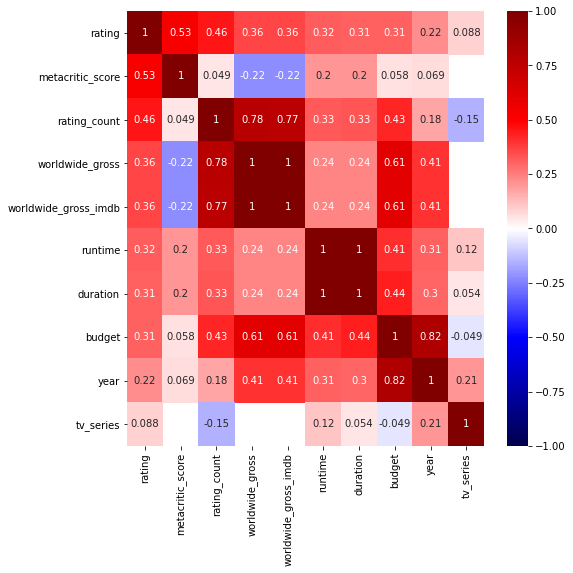

In [82]:
ix = films_df_reordered.iloc[:,:first_cast_column].corr().sort_values('rating', ascending=False).index
films_df_reordered_sorted = films_df_reordered.loc[:, ix]
fig, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(films_df_reordered_sorted.corr(), cmap="seismic", annot=True, vmin=-1, vmax=1, ax=ax);

In [83]:
#sns.heatmap(films_df_reordered.iloc[:,:first_cast_column].corr(), cmap="seismic", annot=True, vmin=-1, vmax=1);

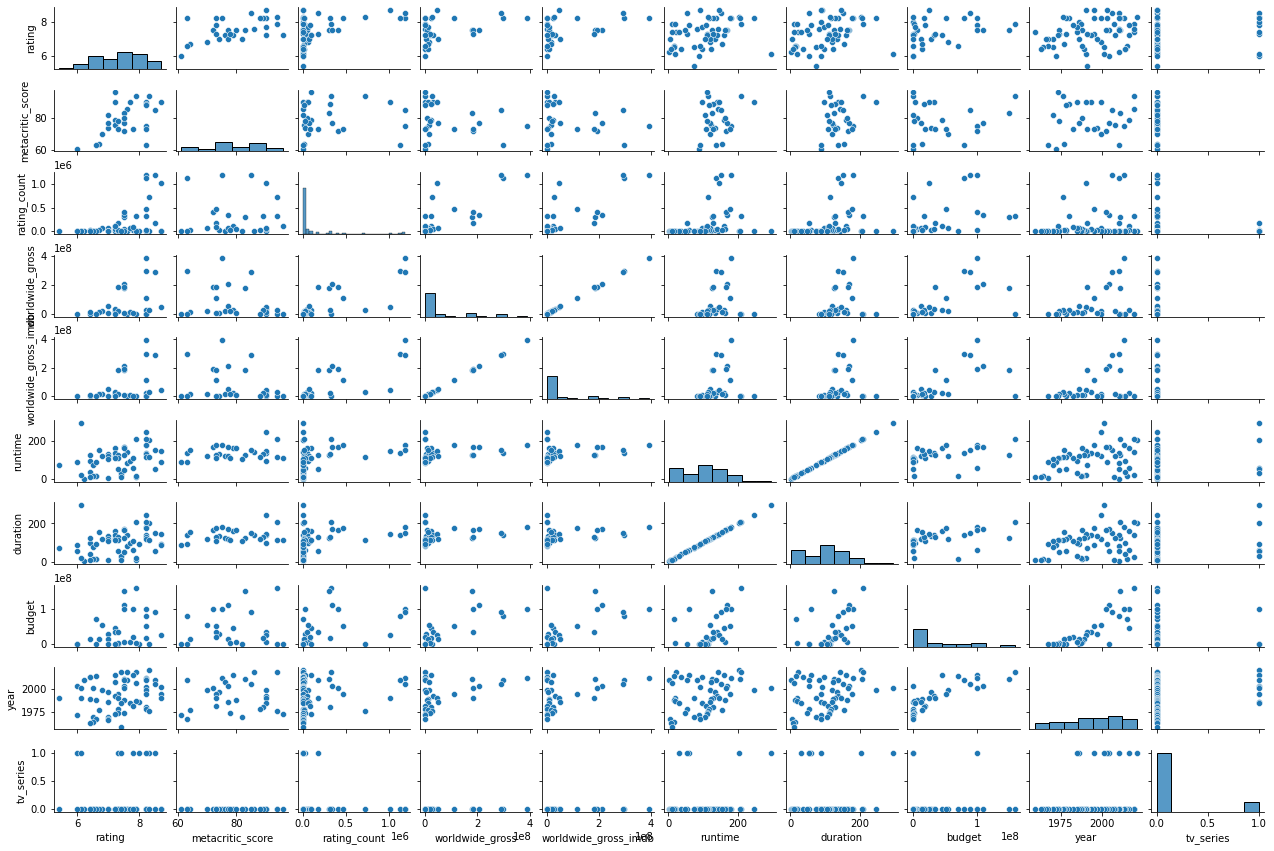

In [84]:
sns.pairplot(films_df_reordered_sorted.iloc[:,:first_cast_column], height=1.2, aspect=1.5);

#### Determine which columns have enough non-null values so they could be used

In [85]:
films_df_reordered['worldwide_gross'].value_counts(dropna=False)

NaN            32
182291969.0     1
16173879.0      1
10763469.0      1
11683.0         1
6443.0          1
110400000.0     1
47092936.0      1
13800000.0      1
389918903.0     1
180047784.0     1
361.0           1
16797191.0      1
10609321.0      1
299461782.0     1
23726626.0      1
289660619.0     1
208370892.0     1
8373585.0       1
910234.0        1
32645.0         1
322563.0        1
2536242.0       1
183124621.0     1
18600000.0      1
32014993.0      1
43184.0         1
156113.0        1
16085.0         1
52293000.0      1
28317378.0      1
23380513.0      1
5686694.0       1
Name: worldwide_gross, dtype: int64

In [86]:
films_to_analyze=films_df_reordered[(films_df_reordered['year'].notnull()) & (films_df_reordered['duration']>30) & (films_df_reordered['rating'].notnull()) & (films_df_reordered['cinematographer']!='') & (films_df_reordered['cinematographer'].notnull())]
films_to_analyze.iloc[:,5:15].head(10)


,budget,worldwide_gross,worldwide_gross_imdb,worldwide_gross_bo,rating,metacritic_score,rating_count,tv_series,documentary,cinematographer
5,NaN,NaN,NaN,NaN,8.3,NaN,1913.0,1.0,1.0,Ellen Kuras
7,159000000.0,910234.0,968853.0,910234.0,7.9,94.0,322963.0,0.0,0.0,Rodrigo Prieto
8,NaN,NaN,NaN,NaN,7.6,86.0,5300.0,0.0,1.0,Howard Alk
9,46000000.0,23726626.0,23834809.0,23726626.0,7.2,79.0,100119.0,0.0,0.0,Rodrigo Prieto
10,100000000.0,NaN,NaN,NaN,7.8,NaN,21636.0,1.0,0.0,Reed Morano
12,NaN,361.0,361.0,,6.4,NaN,611.0,0.0,1.0,Ellen Kuras
13,NaN,NaN,NaN,NaN,6.4,NaN,110.0,0.0,0.0,Fred Schuler
14,100000000.0,389918903.0,392000694.0,389918903.0,8.2,75.0,1182444.0,0.0,0.0,Rodrigo Prieto
15,150000000.0,180047784.0,185770310.0,180047784.0,7.5,83.0,304665.0,0.0,0.0,Robert Richardson
16,NaN,156113.0,156113.0,NaN,8.2,NaN,10599.0,0.0,1.0,Martin Kenzie


In [87]:
first_actor_column = (len(films_to_analyze.columns) - len(dict_of_all_actors))
first_actor_column

15

In [88]:
actor_columns = films_to_analyze.iloc[:, first_actor_column:].columns
actor_columns

Index(['Robert De Niro', 'Martin Scorsese', 'Leonardo DiCaprio',
       'Harvey Keitel', 'Joe Pesci', 'Catherine Scorsese', 'Eric Clapton',
       'Harry Northup', 'Victor Argo', 'Michael Stuhlbarg',
       ...
       'A. Scott Berg', 'Rosamond Bernier', 'John Burgee', 'Dina Chandel',
       'Eleanor Clark', 'Bette Davis', 'Geraldine Fitzgerald', 'Greer Garson',
       'Joan Givner', 'Fred Sica'],
      dtype='object', length=2788)

In [89]:
films_to_analyze[actor_columns].sum()

Robert De Niro          11.0
Martin Scorsese          5.0
Leonardo DiCaprio        5.0
Harvey Keitel            7.0
Joe Pesci                5.0
                        ... 
Bette Davis              1.0
Geraldine Fitzgerald     1.0
Greer Garson             1.0
Joan Givner              1.0
Fred Sica                0.0
Length: 2788, dtype: float64

In [90]:
actors_num_of_appearances = films_to_analyze[actor_columns].sum()
actors_num_of_appearances

Robert De Niro          11.0
Martin Scorsese          5.0
Leonardo DiCaprio        5.0
Harvey Keitel            7.0
Joe Pesci                5.0
                        ... 
Bette Davis              1.0
Geraldine Fitzgerald     1.0
Greer Garson             1.0
Joan Givner              1.0
Fred Sica                0.0
Length: 2788, dtype: float64

In [91]:
appearances_threshold = 3
prevalent_actors_mask = (actors_num_of_appearances >= appearances_threshold)
prevalent_actors_mask

Robert De Niro           True
Martin Scorsese          True
Leonardo DiCaprio        True
Harvey Keitel            True
Joe Pesci                True
                        ...  
Bette Davis             False
Geraldine Fitzgerald    False
Greer Garson            False
Joan Givner             False
Fred Sica               False
Length: 2788, dtype: bool

In [92]:
prevalent_actor_columns = actor_columns[prevalent_actors_mask]
prevalent_actor_columns 

Index(['Robert De Niro', 'Martin Scorsese', 'Leonardo DiCaprio',
       'Harvey Keitel', 'Joe Pesci', 'Catherine Scorsese', 'Eric Clapton',
       'Harry Northup', 'Victor Argo', 'Michael Stuhlbarg', 'Charles Scorsese',
       'Barry Primus', 'Ringo Starr', 'Frank Vincent', 'Bob Dylan',
       'Paul Herman', 'Murray Moston', 'Stephen Graham', 'Verna Bloom',
       'Alec Baldwin', 'Ray Romano', 'Diahnne Abbott', 'Barbara Hershey',
       'Patricia Clarkson'],
      dtype='object')

#### These next few cells are legacy  -----------------------------------------

#### End of legacy code  -----------------------------------------

In [93]:
analysis_columns = ['title', 'year', 'duration', 'cinematographer', 'documentary', 'tv_series','rating', 'rating_count', *prevalent_actor_columns]

In [94]:
analysis_columns

['title',
 'year',
 'duration',
 'cinematographer',
 'documentary',
 'tv_series',
 'rating',
 'rating_count',
 'Robert De Niro',
 'Martin Scorsese',
 'Leonardo DiCaprio',
 'Harvey Keitel',
 'Joe Pesci',
 'Catherine Scorsese',
 'Eric Clapton',
 'Harry Northup',
 'Victor Argo',
 'Michael Stuhlbarg',
 'Charles Scorsese',
 'Barry Primus',
 'Ringo Starr',
 'Frank Vincent',
 'Bob Dylan',
 'Paul Herman',
 'Murray Moston',
 'Stephen Graham',
 'Verna Bloom',
 'Alec Baldwin',
 'Ray Romano',
 'Diahnne Abbott',
 'Barbara Hershey',
 'Patricia Clarkson']

## Dataset partitioned for analysis

In [95]:
films_and_features_to_analyze_df = films_to_analyze[analysis_columns]

In [96]:
x_label = 'year'
y_label = 'rating'
x_ = films_and_features_to_analyze_df[x_label]
y_ = films_and_features_to_analyze_df[y_label]

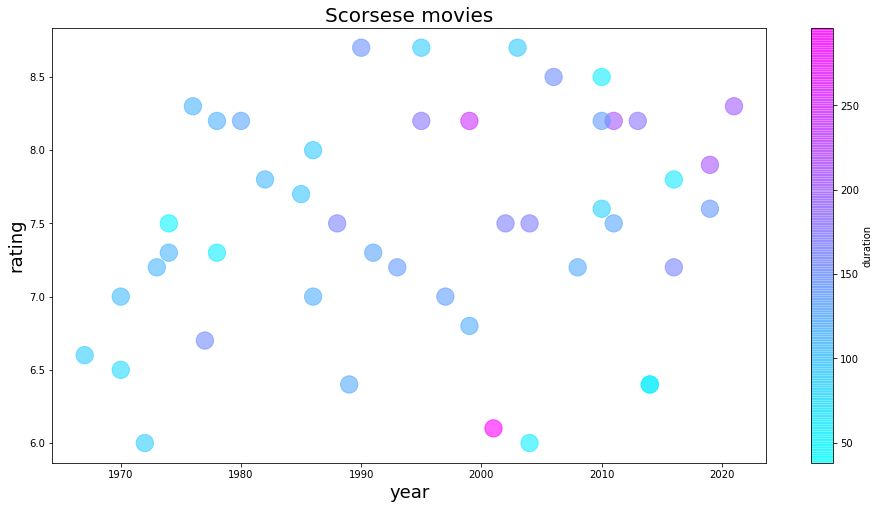

In [97]:
plt.figure(figsize=(16,8))

size_ = 300
alpha_ = .6
plt.xlabel(x_label, fontsize='18')
plt.ylabel(y_label, fontsize='18')
plt.title(director.title() + ' movies', fontsize='20')
cmap=plt.get_cmap("cool")
color_dimension = 'duration'
cm=films_and_features_to_analyze_df[color_dimension].tolist()

category = 'tv_series'
plt.scatter(x=x_, y=y_, marker='o', alpha=alpha_, c=cm,cmap="cool", s=(size_,))
plt.colorbar(label=color_dimension)

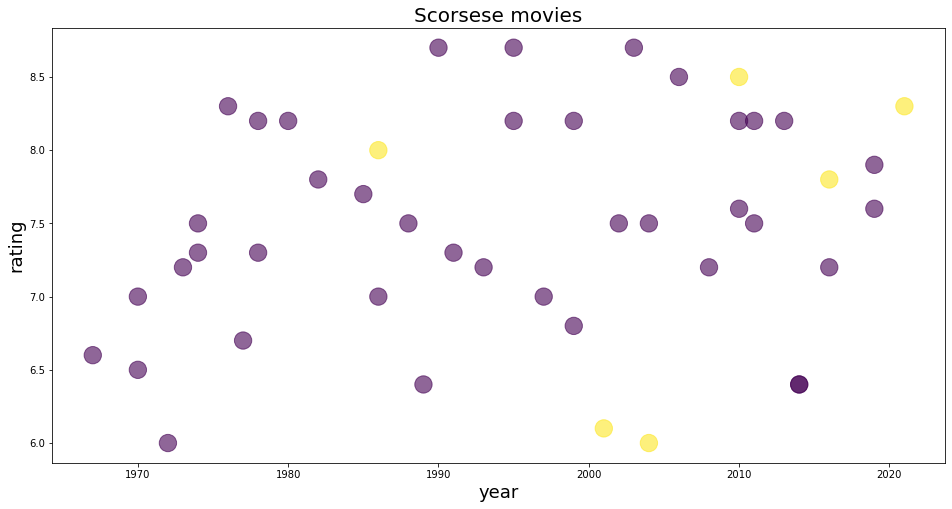

In [98]:
plt.figure(figsize=(16,8))

size_ = 300
alpha_ = .6
plt.xlabel(x_label, fontsize='18')
plt.ylabel(y_label, fontsize='18')
plt.title(director.title() + ' movies', fontsize='20')

category = 'tv_series'
plt.scatter(x=x_, y=y_, marker='o', alpha=alpha_, c = films_and_features_to_analyze_df[category], s=(size_,))

In [99]:
x_label = 'year'
y_label = 'duration'
x_ = films_and_features_to_analyze_df[x_label]
y_ = films_and_features_to_analyze_df[y_label]

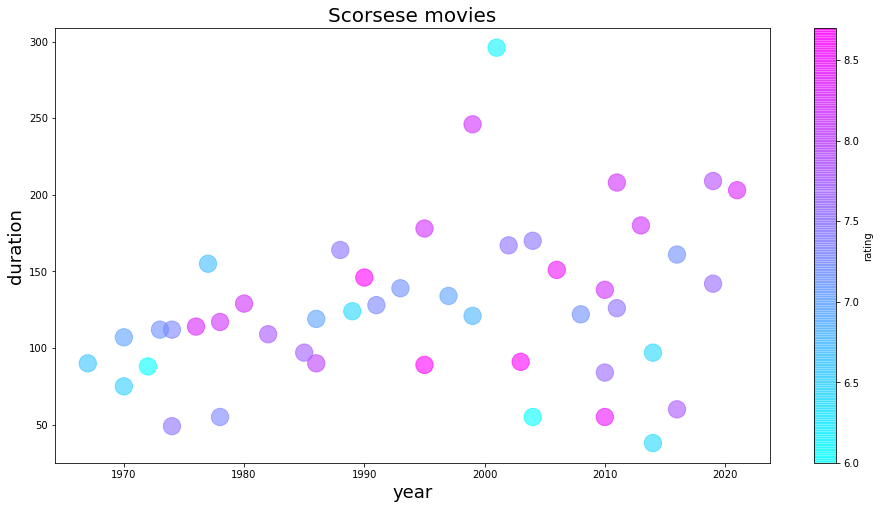

In [100]:
plt.figure(figsize=(16,8))

size_ = 300
alpha_ = .6
plt.xlabel(x_label, fontsize='18')
plt.ylabel(y_label, fontsize='18')
plt.title(director.title() + ' movies', fontsize='20')
cmap=plt.get_cmap("cool")
color_dimension = 'rating'
cm=films_and_features_to_analyze_df[color_dimension ].tolist()
category = 'tv_series'
plt.scatter(x=x_, y=y_, marker='o', alpha=alpha_, c=cm,cmap="cool", s=(size_,))
plt.colorbar(label=color_dimension )

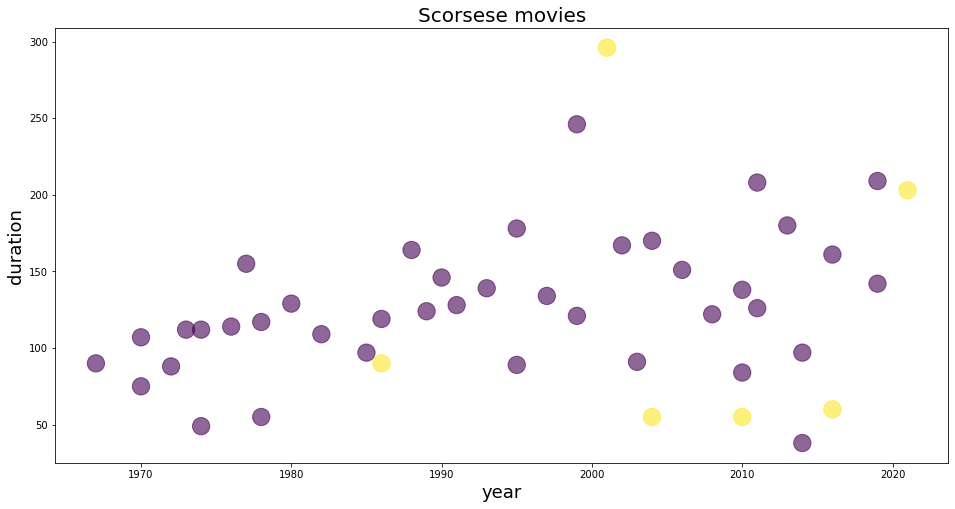

In [101]:
plt.figure(figsize=(16,8))

size_ = 300
alpha_ = .6
plt.xlabel(x_label, fontsize='18')
plt.ylabel(y_label, fontsize='18')
plt.title(director.title() + ' movies', fontsize='20')
category = 'tv_series'
plt.scatter(x=x_, y=y_, marker='o', alpha=alpha_, c = films_and_features_to_analyze_df[category], s=(size_,))


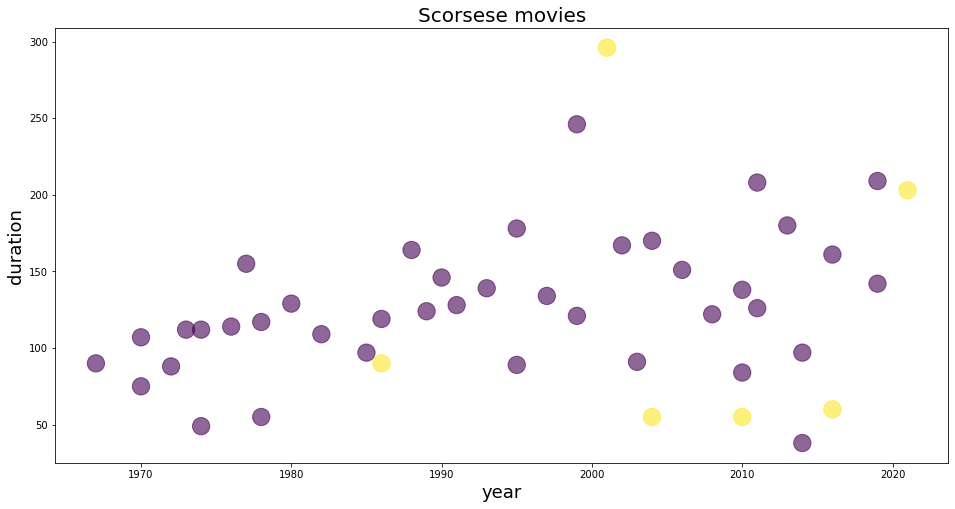

In [102]:
plt.figure(figsize=(16,8))

size_ = 300
alpha_ = .6
plt.xlabel(x_label, fontsize='18')
plt.ylabel(y_label, fontsize='18')
plt.title(director.title() + ' movies', fontsize='20')
category = 'tv_series'
plt.scatter(x=x_, y=y_, marker='o', alpha=alpha_, c = films_and_features_to_analyze_df[category], s=(size_,))


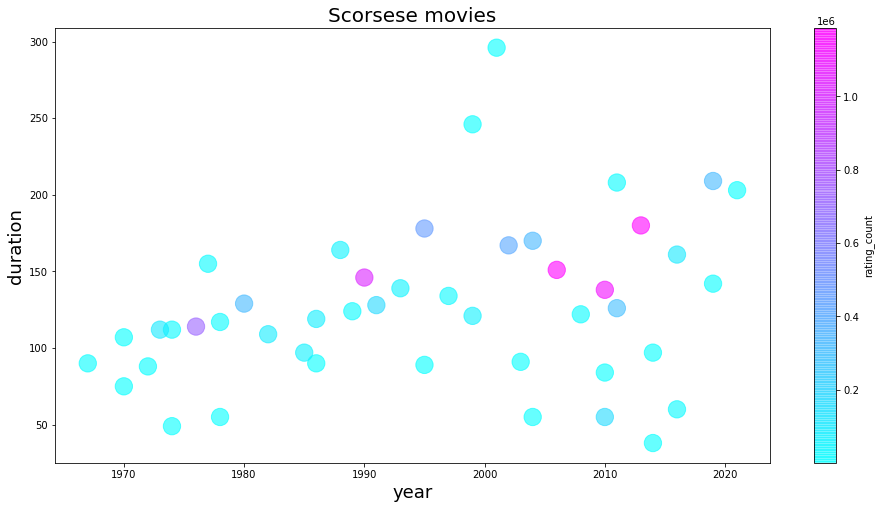

In [103]:
plt.figure(figsize=(16,8))

size_ = 300
alpha_ = .6
plt.xlabel(x_label, fontsize='18')
plt.ylabel(y_label, fontsize='18')
plt.title(director.title() + ' movies', fontsize='20')
cmap=plt.get_cmap("cool")
color_dimension = 'rating_count'
cmap=plt.get_cmap("cool")
cm=films_and_features_to_analyze_df[color_dimension ].tolist()
category = 'tv_series'
plt.scatter(x=x_, y=y_, marker='o', alpha=alpha_, c=cm,cmap="cool", s=(size_,))
plt.colorbar(label=color_dimension )
#plt.scatter(x=x_, y=y_, marker='o', alpha=alpha_, c = films_and_features_to_analyze_df[category], s=(size_,))

In [104]:
x_label = 'year'
y_label = 'rating_count'
x_ = films_and_features_to_analyze_df[x_label]
y_ = films_and_features_to_analyze_df[y_label]

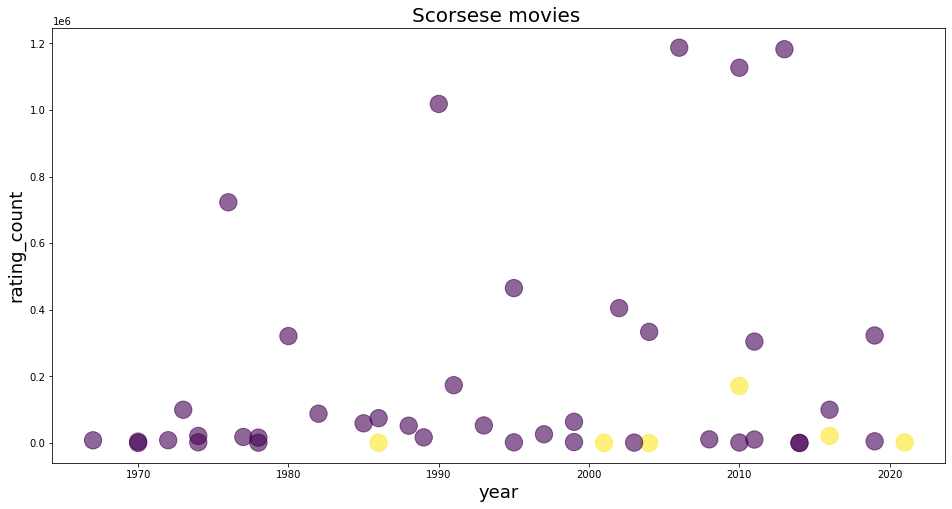

In [105]:
plt.figure(figsize=(16,8))
size_ = 300
alpha_ = .6
plt.xlabel(x_label, fontsize='18')
plt.ylabel(y_label, fontsize='18')
plt.title(director.title() + ' movies ', fontsize='20')
category = 'tv_series'
plt.scatter(x=x_, y=y_, marker='o', alpha=alpha_, c = films_and_features_to_analyze_df[category], s=(size_,))


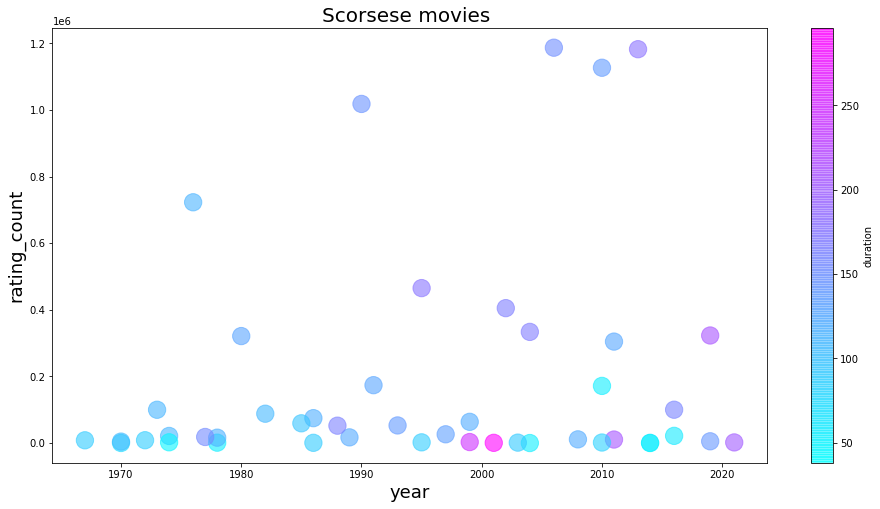

In [106]:
plt.figure(figsize=(16,8))
size_ = 300
alpha_ = .6
plt.xlabel(x_label, fontsize='18')
plt.ylabel(y_label, fontsize='18')
plt.title(director.title() + ' movies ', fontsize='20')
color_dimension = 'duration'

cm=films_and_features_to_analyze_df[color_dimension ].tolist()
cmap=plt.get_cmap("cool")
category = 'tv_series'
plt.scatter(x=x_, y=y_, marker='o', alpha=alpha_, c=cm,cmap="cool", s=(size_,))
plt.colorbar(label=color_dimension )

In [107]:
#films_and_features_to_analyze_df[films_and_features_to_analyze_df['tv_series']!=1]

In [108]:
x_label = 'year'
y_label = 'rating_count'
x_ = films_and_features_to_analyze_df[films_and_features_to_analyze_df['tv_series']!=1][x_label]
y_ = films_and_features_to_analyze_df[films_and_features_to_analyze_df['tv_series']!=1][y_label]

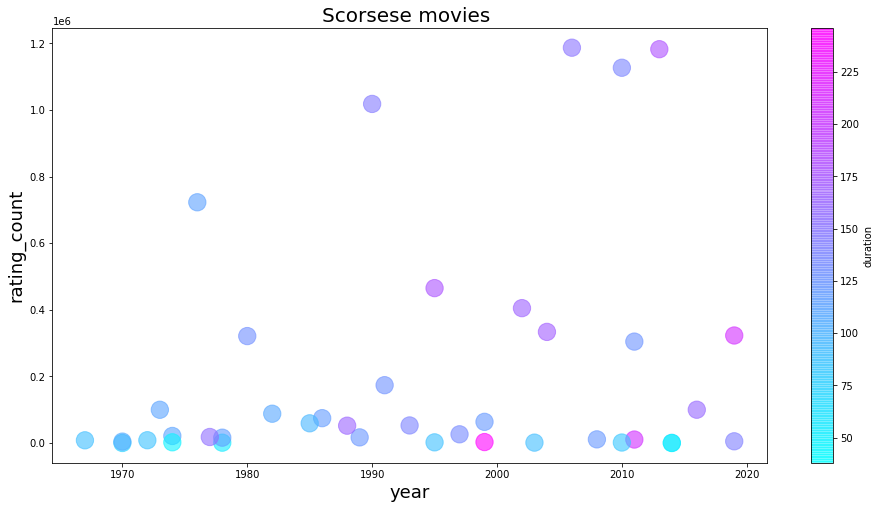

In [109]:
plt.figure(figsize=(16,8))
size_ = 300
alpha_ = .6
plt.xlabel(x_label, fontsize='18')
plt.ylabel(y_label, fontsize='18')
plt.title(director.title() + ' movies ', fontsize='20')
color_dimension = 'duration'

cm=films_and_features_to_analyze_df[films_and_features_to_analyze_df['tv_series']!=1][color_dimension ].tolist()
cmap=plt.get_cmap("cool")
#category = 'tv_series'
plt.scatter(x=x_, y=y_, marker='o', alpha=alpha_, c=cm,cmap="cool", s=(size_,))
plt.colorbar(label=color_dimension )

In [110]:
print( min(x_), max(x_))

1967.0 2019.0


In [111]:
from scipy import signal
signal.unit_impulse(1960) # come back to this to attempt to model "dirac impulse response" 
# for rating count based on year

array([1., 0., 0., ..., 0., 0., 0.])

In [112]:
films_and_features_to_analyze_df[films_and_features_to_analyze_df['duration'] <65]

,title,year,duration,cinematographer,documentary,tv_series,rating,rating_count,Robert De Niro,Martin Scorsese,...,Bob Dylan,Paul Herman,Murray Moston,Stephen Graham,Verna Bloom,Alec Baldwin,Ray Romano,Diahnne Abbott,Barbara Hershey,Patricia Clarkson
10,Vinyl,2016.0,60.0,Reed Morano,0.0,1.0,7.8,21636.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
13,The King of Comedy: Deleted and Extended Scenes,2014.0,38.0,Fred Schuler,0.0,0.0,6.4,110.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
19,Boardwalk Empire,2010.0,55.0,William Coleman,0.0,1.0,8.5,171605.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
27,Lady by the Sea: The Statue of Liberty,2004.0,55.0,Robert Shepard,1.0,1.0,6.0,83.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
53,American Boy: A Profile of - Steven Prince,1978.0,55.0,Michael Chapman,1.0,0.0,7.3,1190.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
58,Italianamerican,1974.0,49.0,Alec Hirschfeld,1.0,0.0,7.5,2295.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Breakdown by **cinematographers** Jack E. Cox, Robert Burks, and Bernard Knowles 

In [113]:
cinematographer = 'Jack E. Cox'

In [114]:
ctgrphr_flix = films_and_features_to_analyze_df[films_and_features_to_analyze_df['cinematographer']==cinematographer]
other_flix = films_and_features_to_analyze_df[films_and_features_to_analyze_df['cinematographer']!=cinematographer]


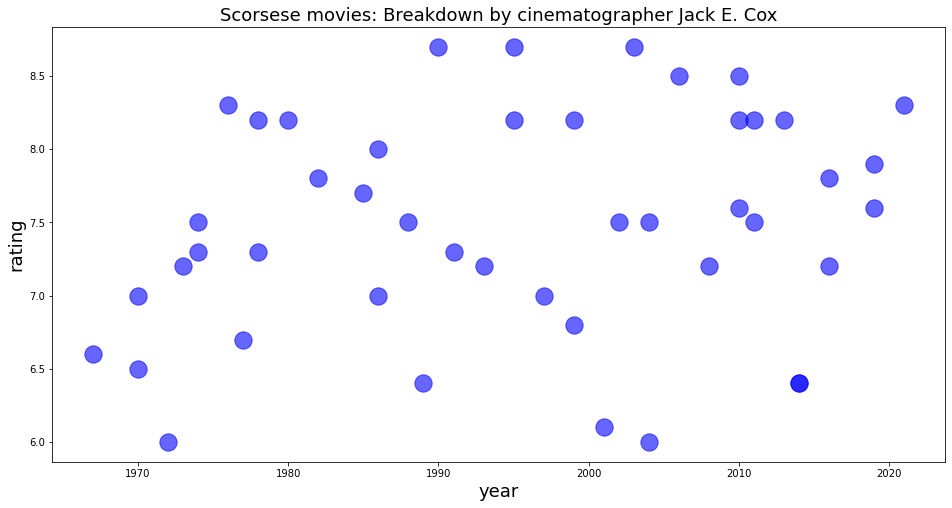

In [115]:
x_label = 'year'
y_label = 'rating'

x_cox = ctgrphr_flix[x_label]
y_cox = ctgrphr_flix[y_label]
x_non_cox = other_flix[x_label]
y_non_cox = other_flix[y_label]

plt.figure(figsize=(16,8))

size_ = 300
alpha_ = .6
plt.xlabel(x_label, fontsize='18')
plt.ylabel(y_label, fontsize='18')
plt.title(director.title() + ' movies: Breakdown by cinematographer ' + cinematographer, fontsize='18')

category = 'tv_series'
plt.scatter(x=x_cox, y=y_cox, marker='o', alpha=alpha_, c = 'r', s=(size_,))
plt.scatter(x=x_non_cox, y=y_non_cox, marker='o', alpha=alpha_, c = 'b', s=(size_,))

plt.show()

In [116]:
cinematographer = 'Robert Burks'

In [117]:

ctgrphr_flix = films_and_features_to_analyze_df[films_and_features_to_analyze_df['cinematographer']==cinematographer]
other_flix = films_and_features_to_analyze_df[films_and_features_to_analyze_df['cinematographer']!=cinematographer]


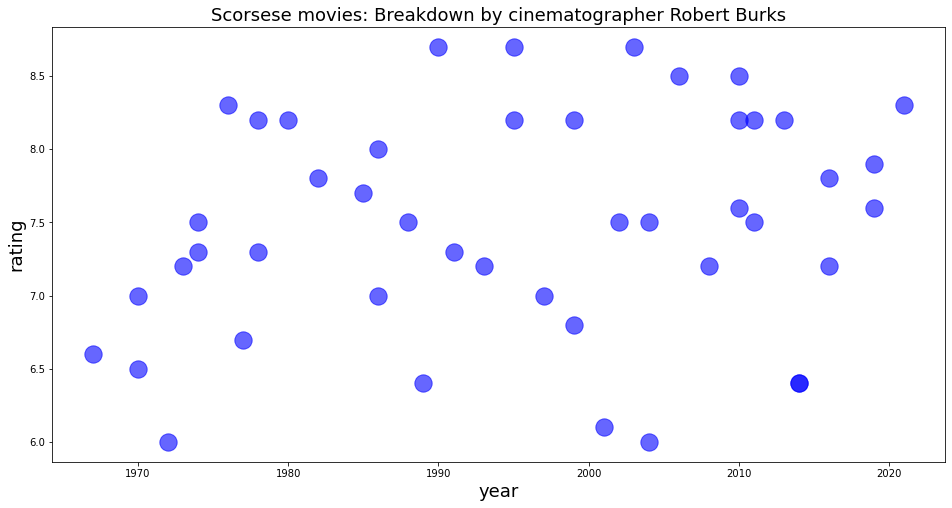

In [118]:
x_label = 'year'
y_label = 'rating'

x_cox = ctgrphr_flix[x_label]
y_cox = ctgrphr_flix[y_label]
x_non_cox = other_flix[x_label]
y_non_cox = other_flix[y_label]

plt.figure(figsize=(16,8))

size_ = 300
alpha_ = .6
plt.xlabel(x_label, fontsize='18')
plt.ylabel(y_label, fontsize='18')
plt.title(director.title() + ' movies: Breakdown by cinematographer ' + cinematographer, fontsize='18')

category = 'tv_series'
plt.scatter(x=x_cox, y=y_cox, marker='o', alpha=alpha_, c = 'r', s=(size_,))
plt.scatter(x=x_non_cox, y=y_non_cox, marker='o', alpha=alpha_, c = 'b', s=(size_,))

plt.show()

In [119]:
cinematographer = 'Bernard Knowles'

In [120]:

ctgrphr_flix = films_and_features_to_analyze_df[films_and_features_to_analyze_df['cinematographer']==cinematographer]
other_flix = films_and_features_to_analyze_df[films_and_features_to_analyze_df['cinematographer']!=cinematographer]


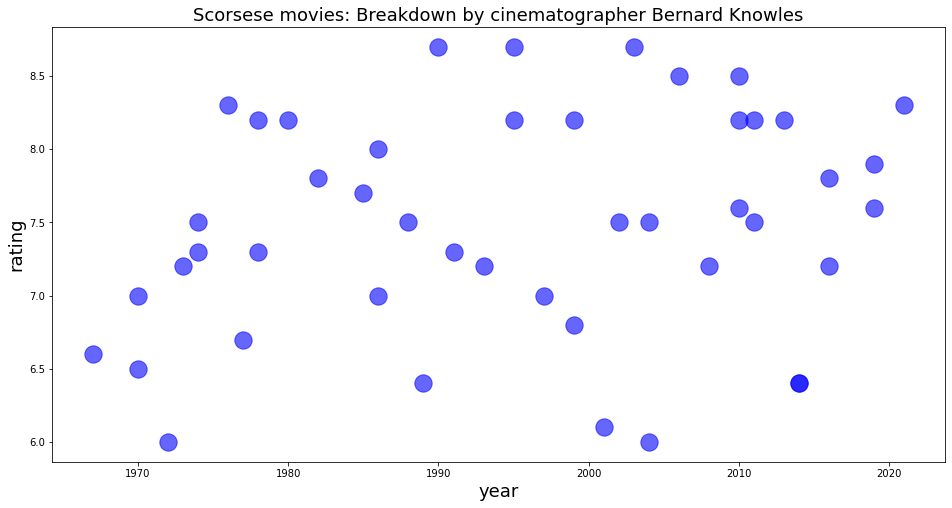

In [121]:
x_label = 'year'
y_label = 'rating'

x_cox = ctgrphr_flix[x_label]
y_cox = ctgrphr_flix[y_label]
x_non_cox = other_flix[x_label]
y_non_cox = other_flix[y_label]

plt.figure(figsize=(16,8))

size_ = 300
alpha_ = .6
plt.xlabel(x_label, fontsize='18')
plt.ylabel(y_label, fontsize='18')
plt.title(director.title() + ' movies: ' + 'Breakdown by cinematographer ' + cinematographer, fontsize='18')

category = 'tv_series'
plt.scatter(x=x_cox, y=y_cox, marker='o', alpha=alpha_, c = 'r', s=(size_,))
plt.scatter(x=x_non_cox, y=y_non_cox, marker='o', alpha=alpha_, c = 'b', s=(size_,))

plt.show()

#### Recode misc. cinematographers to `OTHER` to ameliorate issue of not dropping a column and also to increase the chance it will occur in the test set as well

In [122]:
cinematographer_include_threshold = films_and_features_to_analyze_df['cinematographer'].value_counts().min()
cinematographer_include_threshold

1

In [123]:
value_counts = films_and_features_to_analyze_df['cinematographer'].value_counts() # Specific column 
to_remove = value_counts[value_counts <= cinematographer_include_threshold].index
films_and_features_to_analyze_df['cinematographer'].replace(to_remove, 'OTHER', inplace=True)

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/series.py:4479: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(


### Regression analysis on `rating`,  `duration`, and `year` etc

#### `rating` as target

### Train Test Split

In [124]:
films_and_features_to_analyze_df.columns # review columns we start with

Index(['title', 'year', 'duration', 'cinematographer', 'documentary',
       'tv_series', 'rating', 'rating_count', 'Robert De Niro',
       'Martin Scorsese', 'Leonardo DiCaprio', 'Harvey Keitel', 'Joe Pesci',
       'Catherine Scorsese', 'Eric Clapton', 'Harry Northup', 'Victor Argo',
       'Michael Stuhlbarg', 'Charles Scorsese', 'Barry Primus', 'Ringo Starr',
       'Frank Vincent', 'Bob Dylan', 'Paul Herman', 'Murray Moston',
       'Stephen Graham', 'Verna Bloom', 'Alec Baldwin', 'Ray Romano',
       'Diahnne Abbott', 'Barbara Hershey', 'Patricia Clarkson'],
      dtype='object')

In [125]:
selected_cols = [*films_and_features_to_analyze_df.columns[1:6], *films_and_features_to_analyze_df.columns[7:]]

In [126]:
X= films_and_features_to_analyze_df[selected_cols]
y= films_and_features_to_analyze_df['rating']

In [127]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

### Preprocessing

#### Categorical Variable Preprocessing

In [128]:
cat_ohe_vars = ['cinematographer']
X_train_cat_ohe = X_train[cat_ohe_vars]
#X_train_cat_ohe 

#### OneHotEncoding

In [129]:
#ohe = OneHotEncoder(sparse=False, drop='first')
ohe = OneHotEncoder(sparse=False,  handle_unknown='ignore')
ohe.fit(X_train_cat_ohe)
cats_ohe = ohe.transform(X_train_cat_ohe)


In [130]:
columns=ohe.get_feature_names(cat_ohe_vars)

columns

array(['cinematographer_Ellen Kuras', 'cinematographer_Fred Schuler',
       'cinematographer_Kent L. Wakeford',
       'cinematographer_Michael Ballhaus',
       'cinematographer_Michael Chapman', 'cinematographer_OTHER',
       'cinematographer_Robert Richardson',
       'cinematographer_Rodrigo Prieto'], dtype=object)

In [131]:
X_train_cat_ohe_df = pd.DataFrame(cats_ohe, columns=columns, index=X_train_cat_ohe.index)
X_train_cat_ohe_df.head()

,cinematographer_Ellen Kuras,cinematographer_Fred Schuler,cinematographer_Kent L. Wakeford,cinematographer_Michael Ballhaus,cinematographer_Michael Chapman,cinematographer_OTHER,cinematographer_Robert Richardson,cinematographer_Rodrigo Prieto
21,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
44,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
38,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
15,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
36,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


#### Repeating transformations on testing set

In [132]:
X_test_cat_ohe = X_test[['cinematographer']]
X_test_cat_ohe
cats_ohe_test = ohe.transform(X_test_cat_ohe)

cat_ohe_columns = ohe.get_feature_names(['cinematographer'])
X_test_cat_ohe_df = pd.DataFrame(cats_ohe_test, columns=cat_ohe_columns)

### Continous Variable Preprocessing

#### Select continuous variables from training set

In [133]:
X_train_cont = X_train[['year', 'duration', 'rating_count']]
X_train_cont.head(70)



,year,duration,rating_count
21,2010.0,138.0,1126811.0
44,1989.0,124.0,17072.0
38,1995.0,178.0,465192.0
15,2011.0,126.0,304665.0
36,1995.0,89.0,2146.0
41,1991.0,128.0,173760.0
53,1978.0,55.0,1190.0
46,1988.0,164.0,52212.0
5,2021.0,203.0,1913.0
13,2014.0,38.0,110.0


####  scale the continuous variables in the train set

In [134]:
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()

ss.fit(X_train_cont)
X_train_scaled = ss.transform(X_train_cont)

cont_columns = X_train_cont.columns
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=cont_columns, index=X_train_cont.index)

X_train_scaled_df.head()


,year,duration,rating_count
21,0.840925,0.215599,3.712418
44,-0.472905,-0.046869,-0.451604
38,-0.097525,0.965508,1.229855
15,0.903488,-0.009374,0.627517
36,-0.097525,-0.703040,-0.507611


#### select and scale the continuous variables in the test set

In [135]:
X_test_cont = X_test[['year', 'duration', 'rating_count']]
X_test_cont.head()

,year,duration,rating_count
24,2006.0,151.0,1187014.0
14,2013.0,180.0,1182444.0
19,2010.0,55.0,171605.0
50,1985.0,97.0,59306.0
56,1976.0,114.0,722889.0


In [136]:
X_test_scaled = ss.transform(X_test_cont)

cont_columns = X_test_cont.columns
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=cont_columns, index=X_test_cont.index)

X_test_scaled_df.head()

,year,duration,rating_count
24,0.590672,0.459319,3.938315
14,1.028615,1.003004,3.921167
19,0.840925,-1.340463,0.128243
50,-0.723159,-0.553058,-0.293132
56,-1.286229,-0.234347,2.196800


### Combine the continuous, categorical, and ohe cat features for our testing set


In [137]:
cat_columns = ['documentary', 'tv_series', *prevalent_actor_columns]
X_train_cat_df = X_train[cat_columns]


In [138]:
X_train_combined = pd.concat([X_train_scaled_df, X_train_cat_ohe_df, X_train_cat_df, ], axis='columns')

X_train_combined.head(10)

,year,duration,rating_count,cinematographer_Ellen Kuras,cinematographer_Fred Schuler,cinematographer_Kent L. Wakeford,cinematographer_Michael Ballhaus,cinematographer_Michael Chapman,cinematographer_OTHER,cinematographer_Robert Richardson,...,Bob Dylan,Paul Herman,Murray Moston,Stephen Graham,Verna Bloom,Alec Baldwin,Ray Romano,Diahnne Abbott,Barbara Hershey,Patricia Clarkson
21,0.840925,0.215599,3.712418,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
44,-0.472905,-0.046869,-0.451604,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
38,-0.097525,0.965508,1.229855,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15,0.903488,-0.009374,0.627517,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
36,-0.097525,-0.703040,-0.507611,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
41,-0.347779,0.028122,0.136329,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
53,-1.161102,-1.340463,-0.511198,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
46,-0.535469,0.703040,-0.319750,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
5,1.529122,1.434202,-0.508485,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13,1.091178,-1.659174,-0.515250,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [139]:
X_train.shape

(34, 30)

### Combine the continuous and categorical features for our testing set


In [140]:
X_test_cat_df = X_test[cat_columns]

In [141]:
X_test_scaled_df.shape[0] == X_test_cat_df.shape[0] == X_test_cat_ohe_df.shape[0]


True

In [142]:
X_test_combined = pd.concat([X_test_scaled_df.reset_index(drop=True), X_test_cat_ohe_df.reset_index(drop=True), X_test_cat_df.reset_index(drop=True) ], axis=1)
#X_test_combined = pd.concat([X_test_scaled_df, X_test_cat_ohe_df, X_test_cat_df ], axis=1)

X_test_combined

,year,duration,rating_count,cinematographer_Ellen Kuras,cinematographer_Fred Schuler,cinematographer_Kent L. Wakeford,cinematographer_Michael Ballhaus,cinematographer_Michael Chapman,cinematographer_OTHER,cinematographer_Robert Richardson,...,Bob Dylan,Paul Herman,Murray Moston,Stephen Graham,Verna Bloom,Alec Baldwin,Ray Romano,Diahnne Abbott,Barbara Hershey,Patricia Clarkson
0,0.590672,0.459319,3.938315,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,1.028615,1.003004,3.921167,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.840925,-1.340463,0.128243,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.723159,-0.553058,-0.293132,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,-1.286229,-0.234347,2.196800,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
5,-1.473919,-0.271842,-0.140460,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.152728,-0.103113,-0.276434,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.152728,2.240354,-0.504316,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,-1.536482,-0.721788,-0.483713,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
9,-1.035975,0.046869,0.689587,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Now make predictions by instantiating the Linear Regression Model 

In [143]:
lr = LinearRegression()

lr.fit(X_train_combined, y_train)

LinearRegression()

In [144]:
lr.coef_

array([ 4.89703175e-02,  6.69156152e-01, -1.17751873e-03,  4.79623918e-01,
        9.05511598e-02,  2.19537726e-01, -5.49498052e-01,  1.12935482e+00,
       -2.80589936e-01, -1.73483778e-01, -9.15495857e-01, -1.95681645e-01,
       -1.08210733e+00, -4.39965617e-02,  6.24506444e-01,  1.77359643e+00,
       -4.03517321e-03,  5.82747621e-01,  3.17047415e-01, -2.10519665e+00,
       -5.07493852e-01,  5.60488618e-01,  1.32910458e-02,  1.04407899e+00,
        2.93699232e-01,  1.97236297e+00, -4.61031667e-01,  7.06135592e-02,
       -8.88380726e-01,  2.19537726e-01, -1.87062543e+00, -5.40320609e-01,
       -2.29071764e+00,  2.31391590e+00,  9.05511598e-02,  8.54187850e-01,
       -1.20415104e+00])

In [145]:
y_pred = lr.predict(X_test_combined)

y_pred

array([6.88798524, 9.19798116, 3.54697881, 6.12799106, 9.13696983,
       7.81308088, 7.3882826 , 9.2784147 , 7.98559089, 9.85393217,
       8.10975089, 8.13161547])

In [146]:
from sklearn.metrics import mean_squared_error, r2_score

rmse = np.sqrt(mean_squared_error(y_test, y_pred))

r2 = r2_score(y_test, y_pred)

print(f'RMSE: {rmse:.2f}\nr2: {r2:.2f}')

RMSE: 1.87
r2: -4.07


In [147]:
print(r2)

-4.07486783315231


In [148]:
score = lr.score(X_test_combined, y_test) 
score

-4.07486783315231

# Focus on building up from fewer features
for instance the continous ones

### Train Test Split

In [149]:
films_and_features_to_analyze_df.columns # review columns we start with

Index(['title', 'year', 'duration', 'cinematographer', 'documentary',
       'tv_series', 'rating', 'rating_count', 'Robert De Niro',
       'Martin Scorsese', 'Leonardo DiCaprio', 'Harvey Keitel', 'Joe Pesci',
       'Catherine Scorsese', 'Eric Clapton', 'Harry Northup', 'Victor Argo',
       'Michael Stuhlbarg', 'Charles Scorsese', 'Barry Primus', 'Ringo Starr',
       'Frank Vincent', 'Bob Dylan', 'Paul Herman', 'Murray Moston',
       'Stephen Graham', 'Verna Bloom', 'Alec Baldwin', 'Ray Romano',
       'Diahnne Abbott', 'Barbara Hershey', 'Patricia Clarkson'],
      dtype='object')

In [150]:
selected_cols = ['year', 'duration', 'rating_count']

In [151]:
X= films_and_features_to_analyze_df[selected_cols]
y= films_and_features_to_analyze_df['rating']

In [152]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

### Preprocessing

## For now, ignore these categorical variables

#### Categorical Variable Preprocessing

#### OneHotEncoding

#### Repeating transformations on testing set

### Continous Variable Preprocessing

#### Select continuous variables from training set

In [153]:
X_train_cont = X_train[['year', 'duration', 'rating_count']]
X_train_cont.head()



,year,duration,rating_count
13,2014.0,38.0,110.0
19,2010.0,55.0,171605.0
26,2004.0,170.0,333771.0
34,1999.0,246.0,3024.0
28,2003.0,91.0,1346.0


####  scale the continuous variables in the train set

In [154]:
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()

ss.fit(X_train_cont)
X_train_scaled = ss.transform(X_train_cont)

cont_columns = X_train_cont.columns
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=cont_columns, index=X_train_cont.index)

X_train_scaled_df.head()


,year,duration,rating_count
13,1.177164,-1.623442,-0.515636
19,0.929723,-1.315585,0.022882
26,0.558561,0.766981,0.532107
34,0.249260,2.143285,-0.506486
28,0.496701,-0.663651,-0.511755


#### select and scale the continuous variables in the test set

In [155]:
X_test_cont = X_test[['year', 'duration', 'rating_count']]
X_test_cont.head()

,year,duration,rating_count
44,1989.0,124.0,17072.0
56,1976.0,114.0,722889.0
41,1991.0,128.0,173760.0
53,1978.0,55.0,1190.0
33,1999.0,121.0,63756.0


In [156]:
X_test_scaled = ss.transform(X_test_cont)

cont_columns = X_test_cont.columns
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=cont_columns, index=X_test_cont.index)

X_test_scaled_df.head()

,year,duration,rating_count
44,-0.369342,-0.066046,-0.462373
56,-1.173525,-0.247138,1.753993
41,-0.245621,0.006392,0.029650
53,-1.049804,-1.315585,-0.512245
33,0.249260,-0.120373,-0.315779


### Combine the continuous, categorical, and ohe cat features for our testing set


## for now, ignore these categorical variables

## 'combine' will really just be the continuous variables

In [157]:
X_train_combined = pd.concat([X_train_scaled_df.reset_index(drop=True)], axis='columns')

X_train_combined.head()

,year,duration,rating_count
0,1.177164,-1.623442,-0.515636
1,0.929723,-1.315585,0.022882
2,0.558561,0.766981,0.532107
3,0.249260,2.143285,-0.506486
4,0.496701,-0.663651,-0.511755


In [158]:
X_train_combined.shape

(34, 3)

### Combine the continuous and categorical features for our testing set


In [159]:
#X_test_combined = pd.concat([X_test_scaled_df.reset_index(drop=True), X_test_cat_ohe_df.reset_index(drop=True), X_test_cat_df.reset_index(drop=True) ], axis=1)
X_test_combined = pd.concat([X_test_scaled_df.reset_index(drop=True) ], axis=1)

X_test_combined

,year,duration,rating_count
0,-0.369342,-0.066046,-0.462373
1,-1.173525,-0.247138,1.753993
2,-0.245621,0.006392,0.029650
3,-1.049804,-1.315585,-0.512245
4,0.249260,-0.120373,-0.315779
5,-0.926084,0.024501,0.492654
6,-0.802363,-0.337685,-0.239231
7,1.115303,0.948073,3.197061
8,0.125540,0.115047,-0.433421
9,1.486465,0.259921,-0.499339


### Now make predictions by instantiating the Linear Regression Model 

In [160]:
#X_train_combined

In [161]:
lr = LinearRegression()

lr.fit(X_train_combined,y_train)

LinearRegression()

In [162]:
lr.coef_

array([ 0.18912706, -0.03739   ,  0.2861401 ])

In [163]:

y_pred = lr.predict(X_test_combined)

y_pred

array([7.32384281, 7.81271231, 7.48532068, 7.22759892, 7.48481508,
       7.4884339 , 7.31595308, 8.61382237, 7.41895165, 7.65206077,
       7.53078974, 7.89212148])

In [164]:
from sklearn.metrics import mean_squared_error, r2_score

rmse = np.sqrt(mean_squared_error(y_test, y_pred))

r2 = r2_score(y_test, y_pred)

print(f'RMSE: {rmse:.2f}\nr2: {r2:.2f}')

RMSE: 0.65
r2: 0.17


In [165]:
score = lr.score(X_test_combined, y_test) 
score

0.16672533258590094

## Try to fit with just the year

In [166]:
lr = LinearRegression()

In [167]:
X_train_year_only = X_train_combined.iloc[:, :1]

In [168]:
X_test_year_only = X_test_combined.iloc[:, :1]

In [169]:
#X_train_year_only 

In [170]:
lr.fit(X_train_year_only, y_train)

LinearRegression()

In [171]:
lr.coef_

array([0.23911437])

In [172]:
y_pred = lr.predict(X_test_year_only)

y_pred

array([7.43521446, 7.24292278, 7.46479779, 7.27250612, 7.58313113,
       7.30208945, 7.33167279, 7.79021447, 7.5535478 , 7.87896448,
       7.65708947, 7.87896448])

In [173]:
y_test

44    6.4
56    8.3
41    7.3
53    7.3
33    6.8
52    8.2
51    7.8
14    8.2
35    7.0
8     7.6
27    6.0
7     7.9
Name: rating, dtype: float64

In [174]:
#y_test

In [175]:
from sklearn.metrics import mean_squared_error, r2_score

rmse = np.sqrt(mean_squared_error(y_test, y_pred))

In [176]:
r2 = r2_score(y_test, y_pred)

print(f'RMSE: {rmse:.2f}\nr2: {r2:.2f}')

RMSE: 0.77
r2: -0.18


## Try to fit with just the `year` and `duration`


In [177]:
lr = LinearRegression()

X_train_year_dur_only = X_train_combined.iloc[:, :2]

X_test_year_dur_only = X_test_combined.iloc[:, :2]

#X_train_year_only 

lr.fit(X_train_year_dur_only, y_train)

lr.coef_

y_pred = lr.predict(X_test_year_dur_only)

y_pred

y_test

#y_test

from sklearn.metrics import mean_squared_error, r2_score

rmse = np.sqrt(mean_squared_error(y_test, y_pred))



r2 = r2_score(y_test, y_pred)

print(f'RMSE: {rmse:.2f}\nr2: {r2:.2f}')

RMSE: 0.77
r2: -0.19


## Try to fit with just the `year` and `rating_count`

In [178]:
X_train_combined[['year', 'rating_count']]

,year,rating_count
0,1.177164,-0.515636
1,0.929723,0.022882
2,0.558561,0.532107
3,0.249260,-0.506486
4,0.496701,-0.511755
5,0.682282,3.211411
6,0.434841,0.755949
7,-1.544686,-0.515206
8,-1.049804,-0.464976
9,-0.554923,-0.281278


In [179]:
lr = LinearRegression()

X_train_year_rc_only = X_train_combined[['year', 'rating_count']]

X_test_year_rc_only = X_test_combined[['year', 'rating_count']]



lr.fit(X_train_year_rc_only, y_train)

lr.coef_

y_pred = lr.predict(X_test_year_rc_only)

y_pred

y_test


from sklearn.metrics import mean_squared_error, r2_score

rmse = np.sqrt(mean_squared_error(y_test, y_pred))



r2 = r2_score(y_test, y_pred)

print(f'RMSE: {rmse:.2f}\nr2: {r2:.2f}')

RMSE: 0.64
r2: 0.19


## Feature engineer:  log(`year`) and and log(`rating_count`)

####  scale the continuous variables in the train set

In [180]:
X_train_cont_w_log = copy.deepcopy(X_train_cont) 
X_test_cont_w_log = copy.deepcopy(X_test_cont) 

X_train_cont_w_log['log_year'] = np.log(X_train_cont_w_log.year)
X_test_cont_w_log['log_year'] = np.log(X_test_cont_w_log.year)

X_train_cont_w_log['log_rating_count'] = np.log(X_train_cont_w_log.rating_count)
X_test_cont_w_log['log_rating_count'] = np.log(X_test_cont_w_log.rating_count)

In [181]:
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()

ss.fit(X_train_cont_w_log)
X_train_scaled = ss.transform(X_train_cont_w_log)

cont_columns = X_train_cont_w_log.columns
#X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=cont_columns, index=X_train_cont.index)
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=cont_columns, index=X_train_cont_w_log.index)

X_train_scaled_df.head()

,year,duration,rating_count,log_year,log_rating_count
13,1.177164,-1.623442,-0.515636,1.174468,-2.020505
19,0.929723,-1.315585,0.022882,0.929366,0.912220
26,0.558561,0.766981,0.532107,0.560798,1.177576
34,0.249260,2.143285,-0.506486,0.252813,-0.698687
28,0.496701,-0.663651,-0.511755,0.499262,-1.021555


In [182]:
X_test_scaled = ss.transform(X_test_cont_w_log)

cont_columns = X_test_cont_w_log.columns
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=cont_columns, index=X_test_cont_w_log.index)
#X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=cont_columns, index=X_test_cont.index)

X_test_scaled_df.head()

,year,duration,rating_count,log_year,log_rating_count
44,-0.369342,-0.066046,-0.462373,-0.365474,-0.008289
56,-1.173525,-0.247138,1.753993,-1.173910,1.485828
41,-0.245621,0.006392,0.029650,-0.241568,0.917198
53,-1.049804,-1.315585,-0.512245,-1.049190,-1.070690
33,0.249260,-0.120373,-0.315779,0.252813,0.517280


In [183]:
lr = LinearRegression()

lr.fit(X_train_scaled_df, y_train)

lr.coef_

y_pred = lr.predict(X_test_scaled_df)

y_pred

y_test


from sklearn.metrics import mean_squared_error, r2_score

rmse = np.sqrt(mean_squared_error(y_test, y_pred))



r2 = r2_score(y_test, y_pred)

print(f'RMSE: {rmse:.2f}\nr2: {r2:.2f}')

RMSE: 0.78
r2: -0.22


In [184]:
lr.coef_

array([-71.09837111,  -0.11403436,   0.15396607,  71.32278003,
         0.11003592])

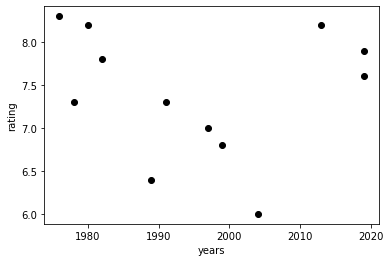

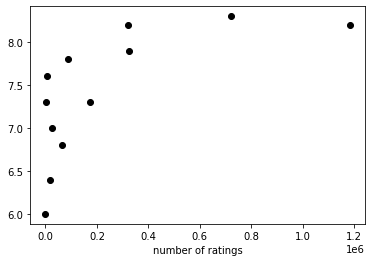

In [185]:
plt.ylabel("rating")
plt.scatter(X_test_cont_w_log['year'], y_test,  color='black')
plt.xlabel('years')
plt.show()
#plt.plot(X_test_cont_w_log['year'], y_pred, color='blue', linewidth=3)
plt.scatter(X_test_cont_w_log['rating_count'], y_test,  color='black')
plt.xlabel('number of ratings')
plt.show()

### Fit to `log_rating_count` and maybe `log_year`


In [186]:
lr = LinearRegression()

X_train_logs_only = X_train_scaled_df[['year','log_rating_count']]

X_test_logs_only = X_test_scaled_df[['year','log_rating_count']]



lr.fit(X_train_logs_only, y_train)

lr.coef_

y_pred = lr.predict(X_test_logs_only)

y_pred

y_test


from sklearn.metrics import mean_squared_error, r2_score

rmse = np.sqrt(mean_squared_error(y_test, y_pred))



r2 = r2_score(y_test, y_pred)

print(f'RMSE: {rmse:.2f}\nr2: {r2:.2f}')

RMSE: 0.62
r2: 0.25


## Attempt LassoCV

In [187]:
#X_cols = [*films_and_features_to_analyze_df.columns[1:3],*films_and_features_to_analyze_df.columns[4:6], *films_and_features_to_analyze_df.columns[7:], ]
#X_cols = [*films_and_features_to_analyze_df.columns[1:3],*films_and_features_to_analyze_df.columns[4:6], *films_and_features_to_analyze_df.columns[7:], ]
X_cols = ['year', 'duration', 'rating_count']

#films_and_features_to_analyze_df_copy = copy.deepcopy(films_and_features_to_analyze_df) 

X= films_and_features_to_analyze_df[X_cols]
y= films_and_features_to_analyze_df['rating']

#selected_cols =cont_columns

X['log_year'] = np.log(X.year)
X['log_rating_count'] = np.log(X.rating_count)

# X_test_cont_w_log = copy.deepcopy(X_test_cont) 

# X_train_cont_w_log['log_year'] = np.log(X_train_cont_w_log.year)
# X_test_cont_w_log['log_year'] = np.log(X_test_cont_w_log.year)

# X_train_cont_w_log['log_rating_count'] = np.log(X_train_cont_w_log.rating_count)
# X_test_cont_w_log['log_rating_count'] = np.log(X_test_cont_w_log.rating_count)

# X= films_and_features_to_analyze_df[X_cols]
# y= films_and_features_to_analyze_df['rating']

<ipython-input-187-ad886dc0e91a>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['log_year'] = np.log(X.year)
<ipython-input-187-ad886dc0e91a>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['log_rating_count'] = np.log(X.rating_count)


In [188]:

X_train_val, X_test, y_train_val, y_test = train_test_split( X, y, test_size=.20, random_state=32)

ss=StandardScaler()

X_train_scaled = ss.fit_transform( X_train_val )

X_test_scaled = ss.fit_transform( X_test )

In [189]:
X.columns

Index(['year', 'duration', 'rating_count', 'log_year', 'log_rating_count'], dtype='object')

In [190]:
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV
from sklearn.metrics import r2_score

model = LassoCV()

In [191]:
model.fit(X_train_scaled,y_train_val)

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001963258783160171, tolerance: 0.0017645517241379307
  model = cd_fast.enet_coordinate_descent_gram(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002179298796367135, tolerance: 0.0017645517241379307
  model = cd_fast.enet_coordinate_descent_gram(


LassoCV()

In [192]:
model.coef_

array([ 0.        , -0.        ,  0.08067205,  0.16493198,  0.301526  ])

In [193]:
list(zip(X_cols, model.coef_))

[('year', 0.0), ('duration', -0.0), ('rating_count', 0.08067205335511123)]

In [194]:
model.score(X_test, y_test)

-3890988369.121672

In [195]:
model.alpha_

0.023478021268996313

## Repartition data set to analyze `budget` and  `worldwide_gross`

In [196]:
films_to_analyze_financial_df = films_to_analyze[(films_to_analyze['budget'] > 0) & (films_df_reordered['worldwide_gross'] > 0)]

<ipython-input-196-e7ff25988abc>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  films_to_analyze_financial_df = films_to_analyze[(films_to_analyze['budget'] > 0) & (films_df_reordered['worldwide_gross'] > 0)]


In [197]:
first_actor_column = (len(films_to_analyze_financial_df.columns) - len(dict_of_all_actors))
first_actor_column


15

In [198]:
actor_columns = films_to_analyze_financial_df.iloc[:, first_actor_column:].columns
actor_columns


Index(['Robert De Niro', 'Martin Scorsese', 'Leonardo DiCaprio',
       'Harvey Keitel', 'Joe Pesci', 'Catherine Scorsese', 'Eric Clapton',
       'Harry Northup', 'Victor Argo', 'Michael Stuhlbarg',
       ...
       'A. Scott Berg', 'Rosamond Bernier', 'John Burgee', 'Dina Chandel',
       'Eleanor Clark', 'Bette Davis', 'Geraldine Fitzgerald', 'Greer Garson',
       'Joan Givner', 'Fred Sica'],
      dtype='object', length=2788)

In [199]:
films_to_analyze_financial_df[actor_columns].sum()

Robert De Niro          9.0
Martin Scorsese         0.0
Leonardo DiCaprio       5.0
Harvey Keitel           5.0
Joe Pesci               4.0
                       ... 
Bette Davis             0.0
Geraldine Fitzgerald    0.0
Greer Garson            0.0
Joan Givner             0.0
Fred Sica               0.0
Length: 2788, dtype: float64

In [201]:
actors_num_of_appearances = films_to_analyze_financial_df[actor_columns].sum()
actors_num_of_appearances

Robert De Niro          9.0
Martin Scorsese         0.0
Leonardo DiCaprio       5.0
Harvey Keitel           5.0
Joe Pesci               4.0
                       ... 
Bette Davis             0.0
Geraldine Fitzgerald    0.0
Greer Garson            0.0
Joan Givner             0.0
Fred Sica               0.0
Length: 2788, dtype: float64

In [202]:
appearances_threshold = 3
prevalent_actors_mask = (actors_num_of_appearances >= appearances_threshold)
prevalent_actors_mask

Robert De Niro           True
Martin Scorsese         False
Leonardo DiCaprio        True
Harvey Keitel            True
Joe Pesci                True
                        ...  
Bette Davis             False
Geraldine Fitzgerald    False
Greer Garson            False
Joan Givner             False
Fred Sica               False
Length: 2788, dtype: bool

In [203]:
prevalent_actor_columns = actor_columns[prevalent_actors_mask]
prevalent_actor_columns 


Index(['Robert De Niro', 'Leonardo DiCaprio', 'Harvey Keitel', 'Joe Pesci',
       'Harry Northup', 'Victor Argo', 'Frank Vincent', 'Paul Herman',
       'Murray Moston'],
      dtype='object')

In [204]:
analysis_columns = ['title', 'year', 'duration', 'budget', 'worldwide_gross','cinematographer', 'documentary', 'tv_series','rating', 'rating_count', *prevalent_actor_columns]
analysis_columns


['title',
 'year',
 'duration',
 'budget',
 'worldwide_gross',
 'cinematographer',
 'documentary',
 'tv_series',
 'rating',
 'rating_count',
 'Robert De Niro',
 'Leonardo DiCaprio',
 'Harvey Keitel',
 'Joe Pesci',
 'Harry Northup',
 'Victor Argo',
 'Frank Vincent',
 'Paul Herman',
 'Murray Moston']

In [205]:
films_and_features_to_analyze_financial_df = films_to_analyze_financial_df[analysis_columns]

In [206]:
films_and_features_to_analyze_financial_df.head(10)

,title,year,duration,budget,worldwide_gross,cinematographer,documentary,tv_series,rating,rating_count,Robert De Niro,Leonardo DiCaprio,Harvey Keitel,Joe Pesci,Harry Northup,Victor Argo,Frank Vincent,Paul Herman,Murray Moston
7,The Irishman,2019.0,209.0,159000000.0,910234.0,Rodrigo Prieto,0.0,0.0,7.9,322963.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
9,Silence,2016.0,161.0,46000000.0,23726626.0,Rodrigo Prieto,0.0,0.0,7.2,100119.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14,The Wolf of Wall Street,2013.0,180.0,100000000.0,389918903.0,Rodrigo Prieto,0.0,0.0,8.2,1182444.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15,Hugo,2011.0,126.0,150000000.0,180047784.0,Robert Richardson,0.0,0.0,7.5,304665.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21,Shutter Island,2010.0,138.0,80000000.0,299461782.0,Robert Richardson,0.0,0.0,8.2,1126811.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
24,The Departed,2006.0,151.0,90000000.0,289660619.0,Michael Ballhaus,0.0,0.0,8.5,1187014.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
26,The Aviator,2004.0,170.0,110000000.0,208370892.0,Robert Richardson,0.0,0.0,7.5,333771.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
30,Gangs of New York,2002.0,167.0,100000000.0,183124621.0,Michael Ballhaus,0.0,0.0,7.5,405055.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
33,Bringing Out the Dead,1999.0,121.0,55000000.0,16797191.0,Robert Richardson,0.0,0.0,6.8,63756.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
35,Kundun,1997.0,134.0,28000000.0,5686694.0,Roger Deakins,0.0,0.0,7.0,26292.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


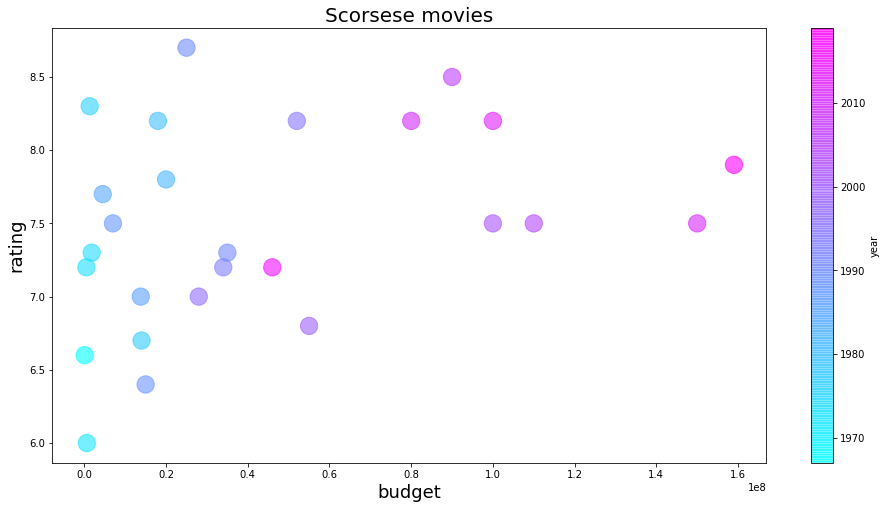

In [207]:
x_label = 'budget'
y_label = 'rating'
x_ = films_and_features_to_analyze_financial_df[x_label]
y_ = films_and_features_to_analyze_financial_df[y_label]

plt.figure(figsize=(16,8))

size_ = 300
alpha_ = .6
plt.xlabel(x_label, fontsize='18')
plt.ylabel(y_label, fontsize='18')
plt.title(director.title() + ' movies', fontsize='20')
cmap=plt.get_cmap("cool")
color_dimension = 'year'
cm=films_and_features_to_analyze_financial_df[color_dimension].tolist()

category = 'tv_series'
plt.scatter(x=x_, y=y_, marker='o', alpha=alpha_, c=cm,cmap="cool", s=(size_,))
plt.colorbar(label=color_dimension)

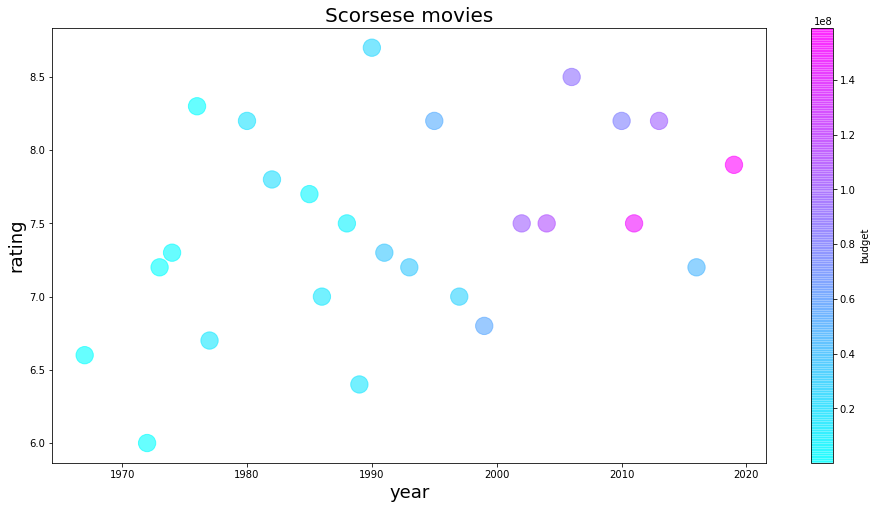

In [208]:
x_label = 'year'
y_label = 'rating'
x_ = films_and_features_to_analyze_financial_df[x_label]
y_ = films_and_features_to_analyze_financial_df[y_label]

plt.figure(figsize=(16,8))

size_ = 300
alpha_ = .6
plt.xlabel(x_label, fontsize='18')
plt.ylabel(y_label, fontsize='18')
plt.title(director.title() + ' movies', fontsize='20')
cmap=plt.get_cmap("cool")
color_dimension = 'budget'
cm=films_and_features_to_analyze_financial_df[color_dimension].tolist()

category = 'tv_series'
plt.scatter(x=x_, y=y_, marker='o', alpha=alpha_, c=cm,cmap="cool", s=(size_,))
plt.colorbar(label=color_dimension)

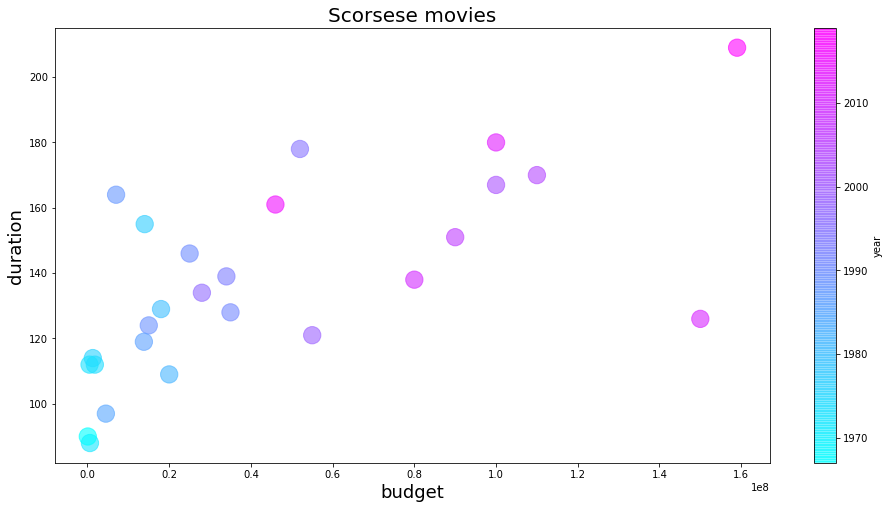

In [209]:
x_label = 'budget'
y_label = 'duration'
x_ = films_and_features_to_analyze_financial_df[x_label]
y_ = films_and_features_to_analyze_financial_df[y_label]

plt.figure(figsize=(16,8))

size_ = 300
alpha_ = .6
plt.xlabel(x_label, fontsize='18')
plt.ylabel(y_label, fontsize='18')
plt.title(director.title() + ' movies', fontsize='20')
cmap=plt.get_cmap("cool")
color_dimension = 'year'
cm=films_and_features_to_analyze_financial_df[color_dimension].tolist()

category = 'tv_series'
plt.scatter(x=x_, y=y_, marker='o', alpha=alpha_, c=cm,cmap="cool", s=(size_,))
plt.colorbar(label=color_dimension)

In [210]:
cinematographer_include_threshold = films_and_features_to_analyze_df['cinematographer'].value_counts().min()
cinematographer_include_threshold

2

In [211]:
value_counts = films_and_features_to_analyze_financial_df['cinematographer'].value_counts() # Specific column 
to_remove = value_counts[value_counts <= cinematographer_include_threshold].index
films_and_features_to_analyze_financial_df['cinematographer'].replace(to_remove, 'OTHER', inplace=True)

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/series.py:4479: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(


In [212]:
selected_cols = [*films_and_features_to_analyze_financial_df.columns[1:8], *films_and_features_to_analyze_financial_df.columns[9:]]

In [213]:
selected_cols

['year',
 'duration',
 'budget',
 'worldwide_gross',
 'cinematographer',
 'documentary',
 'tv_series',
 'rating_count',
 'Robert De Niro',
 'Leonardo DiCaprio',
 'Harvey Keitel',
 'Joe Pesci',
 'Harry Northup',
 'Victor Argo',
 'Frank Vincent',
 'Paul Herman',
 'Murray Moston']

In [214]:
X= films_and_features_to_analyze_financial_df[selected_cols]
y= films_and_features_to_analyze_financial_df['rating']

In [215]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [216]:
### Preprocessing

#### Categorical Variable Preprocessing

cat_ohe_vars = ['cinematographer']
X_train_cat_ohe = X_train[cat_ohe_vars]
#X_train_cat_ohe 

#### OneHotEncoding

In [217]:


#ohe = OneHotEncoder(sparse=False, drop='first')
ohe = OneHotEncoder(sparse=False,  handle_unknown='ignore')
ohe.fit(X_train_cat_ohe)
cats_ohe = ohe.transform(X_train_cat_ohe)


columns=ohe.get_feature_names(cat_ohe_vars)

columns

X_train_cat_ohe_df = pd.DataFrame(cats_ohe, columns=columns, index=X_train_cat_ohe.index)
X_train_cat_ohe_df.head()

#### Repeating transformations on testing set

X_test_cat_ohe = X_test[['cinematographer']]
X_test_cat_ohe
cats_ohe_test = ohe.transform(X_test_cat_ohe)

cat_ohe_columns = ohe.get_feature_names(['cinematographer'])
X_test_cat_ohe_df = pd.DataFrame(cats_ohe_test, columns=cat_ohe_columns)

### Continous Variable Preprocessing

#### Select continuous variables from training set

X_train_cont = X_train[['year', 'duration', 'budget','rating_count']]
X_train_cont.head(70)



####  scale the continuous variables in the train set

from sklearn.preprocessing import StandardScaler

ss = StandardScaler()

ss.fit(X_train_cont)
X_train_scaled = ss.transform(X_train_cont)

cont_columns = X_train_cont.columns
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=cont_columns, index=X_train_cont.index)

X_train_scaled_df.head()


#### select and scale the continuous variables in the test set

X_test_cont = X_test[['year', 'duration', 'budget','rating_count']]
X_test_cont.head()

X_test_scaled = ss.transform(X_test_cont)

cont_columns = X_test_cont.columns
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=cont_columns, index=X_test_cont.index)

X_test_scaled_df.head()

### Combine the continuous, categorical, and ohe cat features for our testing set


cat_columns = ['documentary', 'tv_series', *prevalent_actor_columns]
X_train_cat_df = X_train[cat_columns]


X_train_combined = pd.concat([X_train_scaled_df, X_train_cat_ohe_df, X_train_cat_df, ], axis='columns')

X_train_combined.head(10)

X_train.shape

### Combine the continuous and categorical features for our testing set


X_test_cat_df = X_test[cat_columns]

X_test_scaled_df.shape[0] == X_test_cat_df.shape[0] == X_test_cat_ohe_df.shape[0]


X_test_combined = pd.concat([X_test_scaled_df.reset_index(drop=True), X_test_cat_ohe_df.reset_index(drop=True), X_test_cat_df.reset_index(drop=True) ], axis=1)
#X_test_combined = pd.concat([X_test_scaled_df, X_test_cat_ohe_df, X_test_cat_df ], axis=1)

X_test_combined

### Now make predictions by instantiating the Linear Regression Model 

lr = LinearRegression()

lr.fit(X_train_combined, y_train)

lr.coef_

y_pred = lr.predict(X_test_combined)

y_pred

from sklearn.metrics import mean_squared_error, r2_score

rmse = np.sqrt(mean_squared_error(y_test, y_pred))

r2 = r2_score(y_test, y_pred)

print(f'RMSE: {rmse:.2f}\nr2: {r2:.2f}')

print(r2)

score = lr.score(X_test_combined, y_test) 
score

RMSE: 1.22
r2: -1.73
-1.7331366227253686


-1.7331366227253686

### Look at continous variable including `budget`

In [218]:
films_and_features_to_analyze_financial_df.columns

selected_cols = ['budget', 'rating_count']
#selected_cols = ['year', 'duration', 'budget', 'rating_count']
#selected_cols = ['budget']
X= films_and_features_to_analyze_financial_df[selected_cols]
y= films_and_features_to_analyze_financial_df['rating']

In [219]:


X_train, X_test, y_train, y_test = train_test_split(X, y)

In [220]:
X_train.columns

Index(['budget', 'rating_count'], dtype='object')

In [221]:
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()

ss.fit(X_train)
X_train_scaled = ss.transform(X_train)
X_train_scaled

array([[-0.54102384, -0.55826822],
       [-0.00488387, -0.52412252],
       [-0.37605769, -0.73444075],
       [ 0.69622225,  2.40071595],
       [ 2.32526294,  0.1107151 ],
       [-0.94312882, -0.52447862],
       [-0.58226538,  0.10571261],
       [-0.6688726 , -0.59641362],
       [-0.91632182, -0.74848818],
       [-0.92663221,  1.25002362],
       [ 2.13967603,  0.05858779],
       [-0.66474845, -0.7573166 ],
       [ 0.18070305, -0.62771337],
       [-0.25233308, -0.65866272],
       [ 1.3148453 ,  0.14150491],
       [-0.86064575, -0.64039052],
       [-0.94106674, -0.78508384],
       [ 0.90242994,  2.57222215],
       [ 0.11884074,  0.51589684]])

In [222]:
cont_columns = X_train.columns
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=cont_columns, index=X_train_cont.index)

X_train_scaled_df.head()

,budget,rating_count
46,-0.541024,-0.558268
43,-0.004884,-0.524123
64,-0.376058,-0.734441
57,0.696222,2.400716
59,2.325263,0.110715


In [223]:
X_train_combined = pd.concat([X_train_scaled_df.reset_index(drop=True)], axis='columns')

X_train_combined.head()

,budget,rating_count
0,-0.541024,-0.558268
1,-0.004884,-0.524123
2,-0.376058,-0.734441
3,0.696222,2.400716
4,2.325263,0.110715


In [224]:
#X_test = X_test[['year', 'budget','rating_count']]

X_test = X_test[selected_cols]
X_test.head()

X_test_scaled = ss.transform(X_test)

cont_columns = X_test.columns
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=cont_columns, index=X_test.index)

X_test_scaled_df.head()

,budget,rating_count
30,1.108638,0.344579
46,-0.809094,-0.660600
64,-0.951893,-0.785719
44,-0.644128,-0.760707
43,-0.437920,2.091217


In [225]:
X_test_combined = pd.concat([X_test_scaled_df.reset_index(drop=True) ], axis=1)

X_test_combined

,budget,rating_count
0,1.108638,0.344579
1,-0.809094,-0.660600
2,-0.951893,-0.785719
3,-0.644128,-0.760707
4,-0.437920,2.091217
5,-0.231712,-0.314334
6,1.108638,2.559203


In [226]:
lr = LinearRegression()

lr.fit(X_train_combined,y_train)

lr.coef_

array([0.01849384, 0.46577637])

In [227]:
y_pred = lr.predict(X_test_combined)

y_pred

array([7.66521009, 7.16155545, 7.10063698, 7.11797894, 8.45015107,
       7.33351585, 8.69672984])

In [228]:

from sklearn.metrics import mean_squared_error, r2_score

rmse = np.sqrt(mean_squared_error(y_test, y_pred))

r2 = r2_score(y_test, y_pred)

print(f'RMSE: {rmse:.2f}\nr2: {r2:.2f}')

RMSE: 0.42
r2: 0.69


In [269]:
plot_df = films_and_features_to_analyze_financial_df[['year', 'rating']]

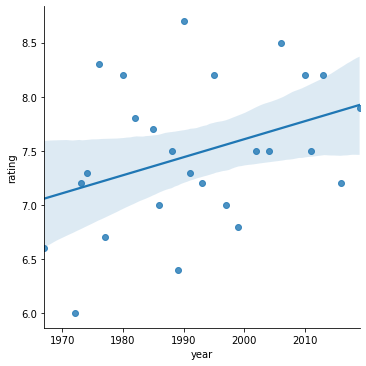

In [273]:
sns.lmplot(x='year', y='rating', data=plot_df,
           fit_reg=True);

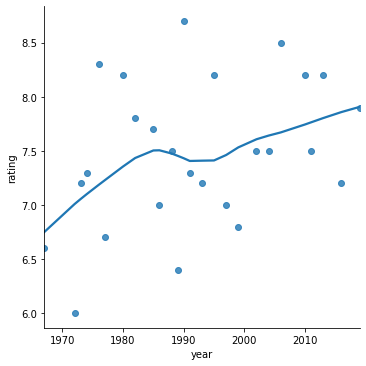

In [282]:
cmap=plt.get_cmap("cool")
color_dimension = 'rating_count'
cm=films_and_features_to_analyze_financial_df[color_dimension].tolist()
cmap='cool'
sns.lmplot(x='year', y='rating', data=plot_df,
           lowess=True);

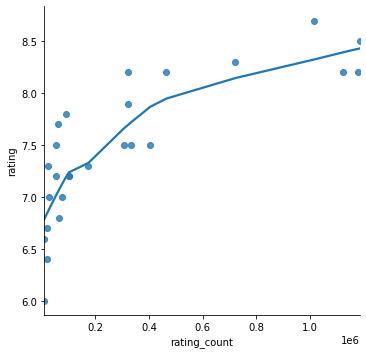

In [266]:
plot_df = films_and_features_to_analyze_financial_df[['rating_count', 'rating']]
sns.lmplot(x='rating_count', y='rating', data=plot_df,  lowess=True)
#sns.lmplot(x='rating_count', y='rating', data=plot_df, scatter_kws={"s": 80});

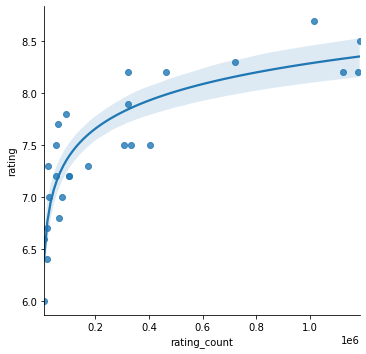

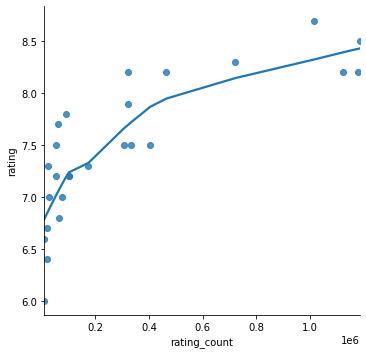

In [283]:
plot_df = films_and_features_to_analyze_financial_df[['rating_count', 'rating']]
sns.lmplot(x='rating_count', y='rating', data=plot_df,  logx=True)

In [229]:
X_train_combined.head()

,budget,rating_count
0,-0.541024,-0.558268
1,-0.004884,-0.524123
2,-0.376058,-0.734441
3,0.696222,2.400716
4,2.325263,0.110715


In [230]:
X_train_cont

,year,duration,budget,rating_count
46,1988.0,164.0,7000000.0,52212.0
43,1990.0,146.0,25000000.0,1018169.0
64,1967.0,90.0,75000.0,8292.0
57,1974.0,112.0,1800000.0,21361.0
59,1973.0,112.0,500000.0,99994.0
55,1977.0,155.0,14000000.0,18262.0
38,1995.0,178.0,52000000.0,465192.0
39,1993.0,139.0,34000000.0,52892.0
41,1991.0,128.0,35000000.0,173760.0
15,2011.0,126.0,150000000.0,304665.0


## include `log(year)` `budget^2` and `log(rating_count)`

In [238]:
X_train_cont_w_log = copy.deepcopy(X_train_cont) 
X_test_cont_w_log = copy.deepcopy(X_test_cont) 

X_train_cont_w_log['log_year'] = np.log(X_train_cont_w_log.year)
X_test_cont_w_log['log_year'] = np.log(X_test_cont_w_log.year)

#X_train_cont_w_log['log_budget'] = np.log(X_train_cont_w_log.budget)
#X_test_cont_w_log['log_budget'] = np.log(X_test_cont_w_log.budget)
#X_train_cont_w_log['pow_budget'] = X_train_cont_w_log.budget**2
#X_test_cont_w_log['pow_budget'] =  X_test_cont_w_log.budget**2


X_train_cont_w_log['log_rating_count'] = np.log(X_train_cont_w_log.rating_count)
X_test_cont_w_log['log_rating_count'] = np.log(X_test_cont_w_log.rating_count)


In [245]:
# films_and_features_to_analyze_financial_df.columns

#selected_cols = [ 'log_year', 'log_budget', 'log_rating_count']
selected_cols = ['year','budget', 'rating_count', 'log_year', 'pow_budget', 'log_rating_count']
#selected_cols = ['log_year', 'log_budget', 'log_rating_count']
# #selected_cols = ['year', 'duration', 'budget', 'rating_count']
# #selected_cols = ['budget']
# X= films_and_features_to_analyze_financial_df[selected_cols]
# y= films_and_features_to_analyze_financial_df['rating']

X_train_cont_w_log = X_train_cont_w_log[ selected_cols ]
X_test_cont_w_log  = X_test_cont_w_log[ selected_cols ]

# X_train, X_test, y_train, y_test = train_test_split(X, y)

# X_train.columns

from sklearn.preprocessing import StandardScaler

ss = StandardScaler()

ss.fit(X_train_cont_w_log)
X_train_scaled = ss.transform(X_train_cont_w_log)
X_train_scaled.shape

cont_columns = X_train_cont_w_log.columns
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=cont_columns, index=X_train_cont_w_log.index)
X_train_scaled_df.head()

X_test_scaled_df = ss.transform(X_test_cont_w_log)

In [246]:
X_test_scaled_df

array([[ 1.70687452,  0.5036477 , -0.24429263],
       [ 1.29390182,  0.77490596,  1.36208252],
       [-0.44019138, -0.6358066 , -0.59177327],
       [ 0.53357333,  0.5912388 , -0.54376172],
       [ 0.39488239,  0.26030437, -1.13155595],
       [-0.78962975,  0.04372688,  0.52925478],
       [-1.35057075, -1.62347134, -1.87969446]])

In [247]:
cont_columns = X_test_cont_w_log.columns
cont_columns

Index(['log_year', 'log_budget', 'log_rating_count'], dtype='object')

In [248]:
X_test_scaled_df

array([[ 1.70687452,  0.5036477 , -0.24429263],
       [ 1.29390182,  0.77490596,  1.36208252],
       [-0.44019138, -0.6358066 , -0.59177327],
       [ 0.53357333,  0.5912388 , -0.54376172],
       [ 0.39488239,  0.26030437, -1.13155595],
       [-0.78962975,  0.04372688,  0.52925478],
       [-1.35057075, -1.62347134, -1.87969446]])

In [249]:
cont_columns = X_test_cont_w_log.columns
X_test_scaled_df = pd.DataFrame(X_test_scaled_df, columns=cont_columns, index=X_test_cont_w_log.index)
#X_test_scaled_df = pd.DataFrame(X_test_scaled)


In [250]:
# X_train_combined = pd.concat([X_train_scaled_df.reset_index(drop=True)], axis='columns')

# X_train_combined.head()


# X_test_cont = X_test[['year','budget', 'rating_count', 'log_year', 'log_budget', 'log_rating_count']]
# X_test_cont.head()




X_test_scaled_df.head()

# X_test_combined = pd.concat([X_test_scaled_df.reset_index(drop=True) ], axis=1)

# X_test_combined

lr = LinearRegression()

lr.fit(X_train_scaled_df,y_train)

lr.coef_

y_pred = lr.predict(X_test_scaled_df)

y_pred



from sklearn.metrics import mean_squared_error, r2_score

rmse = np.sqrt(mean_squared_error(y_test, y_pred))

r2 = r2_score(y_test, y_pred)

print(f'RMSE: {rmse:.2f}\nr2: {r2:.2f}')

X_train_scaled_df.head()

RMSE: 0.78
r2: -0.07


,log_year,log_budget,log_rating_count
46,-0.230951,-0.419229,-0.676312
43,-0.091632,0.204753,1.294806
64,-1.702316,-2.642772,-1.897305
57,-1.210122,-1.084954,-1.269379
59,-1.280329,-1.712842,-0.245122
